# Проект: Линейные модели в машинном обучении

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

<b>Цель исследования</b> 
Разработка модели для интернет-магазина «В один клик», которая предскажет вероятность снижения покупательской активности постоянных клиентов. На основе модели необходимо выделить сегменты покупателей и разработать персонализированные предложения для повышения их активности.
- Проанализировать данные.   
- Предсказать вероятность снижения покупательской активности клиентов на ближайшие три месяца.
- Разработать персонализированные предложения для удержания активных клиентов.

<b>Ход исследования</b>   

Данные для работы находятся в нескольких таблицах.

1. `market_file.csv` Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. `market_money.csv` Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. `market_time.csv` — Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
4. `money.csv` - Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Перед тем, как приступить непосредственно к целям исследования, необходимо будет выполнить:
1. Загрузка и первичная проверка данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Объединение таблиц в итоговый датафрейм.
5. Корреляционный анализ и устранение мультиколлинеарности.
6. Построение и обучение моделей в пайплайне.
7. Подбор гиперпараметров и выбор лучшей модели.
8. Анализ важности признаков.
9. Сегментация клиентов и выработка рекомендаций.
10. Финальные выводы и оформление проекта.

#### Загрузка и изучение данных

In [1]:
pip install scikit-learn==1.3.2 -q 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install thefuzz -q 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install phik -q 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install shap -q 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz
from itertools import combinations
from phik import phik_matrix
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
from pandas.api.types import is_integer_dtype
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, f1_score
import shap

import warnings
warnings.filterwarnings('ignore')

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [7]:
market_file = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/project_git/market_file.csv')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

`market_file` состоит из 1300 записей и 13 столбцов, все данные полные, без пропусков. Требуется изменение типа данных object на category

In [9]:
market_money = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/project_git/market_money.csv')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


`market_money` состоит из 3900 записей и 3 столбцов, все данные полные, без пропусков. Требуется изменение типа данных object на category

In [11]:
market_time = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/project_git/market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [12]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


`market_time` состоит из 2600 записей и 3 столбцов, все данные полные, без пропусков. Требуется изменение типа данных object на category

In [13]:
money = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/project_git/money.csv', sep = ';', decimal = ',')
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [14]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


`money` состоит из 1300 записей и 2 столбцов, все данные полные, без пропусков.

#### Предобработка данных

Выполним предобработку данных. Изменим названия столбцов, типы данных, где это необходимо. Проведем проверку на явные и неявные дубликаты в данных.

##### Изменение наименования столбцов

In [15]:
market_file.rename(columns={
    'Покупательская активность': 'purchase_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'allow_msg',
    'Маркет_актив_6_мес': 'market_activ_6_month',
    'Маркет_актив_тек_мес': 'market_activ_now_month',
    'Длительность': 'reg_days',
    'Акционные_покупки': 'promo_purch_share',
    'Популярная_категория': 'popular_cat',
    'Средний_просмотр_категорий_за_визит': 'avg_cat_per_visit',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_prod_qtr',
    'Ошибка_сервиса': 'service_error',
    'Страниц_за_визит': 'pages_per_visit'
}, inplace=True)
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1300 non-null   int64  
 1   purchase_activity       1300 non-null   object 
 2   service_type            1300 non-null   object 
 3   allow_msg               1300 non-null   object 
 4   market_activ_6_month    1300 non-null   float64
 5   market_activ_now_month  1300 non-null   int64  
 6   reg_days                1300 non-null   int64  
 7   promo_purch_share       1300 non-null   float64
 8   popular_cat             1300 non-null   object 
 9   avg_cat_per_visit       1300 non-null   int64  
 10  unpaid_prod_qtr         1300 non-null   int64  
 11  service_error           1300 non-null   int64  
 12  pages_per_visit         1300 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 132.2+ KB


In [16]:
market_money.rename(columns={
    'Период': 'period',
    'Выручка': 'revenue'
}, inplace=True)
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [17]:
market_time.rename(columns={
    'Период': 'period_time',
    'минут': 'minutes_on_site'
}, inplace=True)
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2600 non-null   int64 
 1   period_time      2600 non-null   object
 2   minutes_on_site  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [18]:
money.rename(columns={
    'Прибыль': 'avg_profit_3_month'
}, inplace=True)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1300 non-null   int64  
 1   avg_profit_3_month  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


##### Изменение типов данных

Для дальнейшей работы с данными потребуется изменить типы столбцов object на category, чтобы они соответствовали их семантике.

In [19]:
market_file = market_file.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      1300 non-null   int64   
 1   purchase_activity       1300 non-null   category
 2   service_type            1300 non-null   category
 3   allow_msg               1300 non-null   category
 4   market_activ_6_month    1300 non-null   float64 
 5   market_activ_now_month  1300 non-null   int64   
 6   reg_days                1300 non-null   int64   
 7   promo_purch_share       1300 non-null   float64 
 8   popular_cat             1300 non-null   category
 9   avg_cat_per_visit       1300 non-null   int64   
 10  unpaid_prod_qtr         1300 non-null   int64   
 11  service_error           1300 non-null   int64   
 12  pages_per_visit         1300 non-null   int64   
dtypes: category(4), float64(2), int64(7)
memory usage: 97.2 KB


In [20]:
market_money = market_money.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       3900 non-null   int64   
 1   period   3900 non-null   category
 2   revenue  3900 non-null   float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 65.0 KB


In [21]:
market_time = market_time.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               2600 non-null   int64   
 1   period_time      2600 non-null   category
 2   minutes_on_site  2600 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 43.4 KB


#####  Анализ дубликатов

По данным мы видим, что пропусков в таблицах нет. Необходимо так же проверить данные на дубликаты. Сначала неявные, потом полные.

In [22]:
cat_cols_market_file = market_file.select_dtypes(include='category').columns

for col in cat_cols_market_file:
    print(f"\nПохожие значения в столбце '{col}':")
    unique_vals = market_file[col].astype(str).unique()
    for v1, v2 in combinations(unique_vals, 2):
        if fuzz.ratio(v1, v2) >= 85:
            print(f"  {v1} <-> {v2}")


Похожие значения в столбце 'purchase_activity':

Похожие значения в столбце 'service_type':
  стандартт <-> стандарт

Похожие значения в столбце 'allow_msg':

Похожие значения в столбце 'popular_cat':


In [23]:
market_file['service_type'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: service_type, dtype: int64

Выявлены неявные дубликаты в написании типа сервиса - стандарт.

In [24]:
market_file['service_type'] = market_file['service_type'].astype(str).str.replace('стандартт', 'стандарт').astype('category')
market_file['service_type'].value_counts()

стандарт    924
премиум     376
Name: service_type, dtype: int64

In [25]:
cat_cols_market_money = market_money.select_dtypes(include='category').columns

for col in cat_cols_market_money:
    print(f"\nПохожие значения в столбце '{col}':")
    unique_vals = market_money[col].astype(str).unique()
    for v1, v2 in combinations(unique_vals, 2):
        if fuzz.ratio(v1, v2) >= 85:
            print(f"  {v1} <-> {v2}")


Похожие значения в столбце 'period':
  препредыдущий_месяц <-> предыдущий_месяц


In [26]:
market_money['period'].value_counts()

предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
Name: period, dtype: int64

В данном случае это не дубликат, а обозначение -2 месяца от текущего. Для единого стиля я уберу символ "_".

In [27]:
market_money['period'] = market_money['period'].astype(str).str.replace('_', ' ').astype('category')
market_money['period'].value_counts()

предыдущий месяц       1300
препредыдущий месяц    1300
текущий месяц          1300
Name: period, dtype: int64

In [28]:
cat_cols_market_time = market_time.select_dtypes(include='category').columns

for col in cat_cols_market_time:
    print(f"\nПохожие значения в столбце '{col}':")
    unique_vals = market_time[col].astype(str).unique()
    for v1, v2 in combinations(unique_vals, 2):
        if fuzz.ratio(v1, v2) >= 85:
            print(f"  {v1} <-> {v2}")


Похожие значения в столбце 'period_time':


В таблице `market_time` дубликатов не выявлено, однако при первичном просмотре данных таблице видно опечатку в данных столбца периода.

In [29]:
market_time['period_time'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: period_time, dtype: int64

In [30]:
market_time['period_time'] = market_time['period_time'].astype(str).str.replace('_', ' ')\
    .str.replace('предыдцщий', 'предыдущий').astype('category')
market_time['period_time'].value_counts()

предыдущий месяц    1300
текущий месяц       1300
Name: period_time, dtype: int64

In [31]:
market_file['popular_cat'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: popular_cat, dtype: int64

In [32]:
market_file['popular_cat'] = market_file['popular_cat'].astype(str).str.replace('аксесуары', 'аксессуары').astype('category')
market_file['popular_cat'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксессуары                  223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: popular_cat, dtype: int64

In [33]:
num_cols_market_file = market_file.select_dtypes(include='number').columns

# Проверка каждого числового столбца
for col in num_cols_market_file:
    q1 = market_file[col].quantile(0.25)
    q3 = market_file[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = market_file[(market_file[col] < lower_bound) | (market_file[col] > upper_bound)]
    print(f"{col}: {len(outliers)} аномальных значений")

id: 0 аномальных значений
market_activ_6_month: 36 аномальных значений
market_activ_now_month: 631 аномальных значений
reg_days: 0 аномальных значений
promo_purch_share: 168 аномальных значений
avg_cat_per_visit: 0 аномальных значений
unpaid_prod_qtr: 14 аномальных значений
service_error: 0 аномальных значений
pages_per_visit: 0 аномальных значений


В заключение, после исправления неявных дубликатов, проведем проверку на явные дубли данных.

In [34]:
len(market_file[market_file.duplicated()])

0

In [35]:
len(market_money[market_money.duplicated()])

0

In [36]:
len(market_time[market_time.duplicated()])

0

In [37]:
len(money[money.duplicated()])

0

Полных дубликатов в данных не обнаружено. В результате предобработки данных, было исправлено наименорвание столбцов, приведение в соответствие типов данных, исправление неявных дубликатов и проверка на полные дубликаты данных.

#### Исследовательский анализ данных

#####  Статистический анализ числовых признаков

In [38]:
market_file.describe()

,id,market_activ_6_month,market_activ_now_month,reg_days,promo_purch_share,avg_cat_per_visit,unpaid_prod_qtr,service_error,pages_per_visit
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


`market_activ_6_month` - Значения от 0.9 до 6.6 — разброс небольшой, распределение близко к нормальному. Возможны выбросы в районе 0.9.   
`market_activ_now_month` - Почти все клиенты имеют 4.0 активности, 25–75% = [4.0–4.0]. Низкая дисперсия, почти константа — может быть малоинформативным.   
`reg_days` - Диапазон от 110 до 1079. Есть заметные отличия между новыми и старыми клиентами.    
`promo_purch_share` - Варьируется от 0 до 0.99. Медиана — 0.24, 75% — 0.3. Есть выбросы ближе к 1.0 — такие клиенты чувствительны к скидкам.  
`avg_cat_per_visit` - От 1 до 6, медиана — 3.0.     
`unpaid_prod_qtr` - Медиана — 3.0, разброс до 10. Возможно, у клиентов с высоким значением — проблемы с завершением покупки. 
`service_error` - От 0 до 9, медиана — 4.0. Возможен умеренный вклад в снижение активности.   
`pages_per_visit` - Разброс от 1 до 20, медиана — 8.0. Выбросов нет, может быть полезным для модели.    

Теперь построим графики распределния и боксплот, для оценки качества и разброса наших данных.

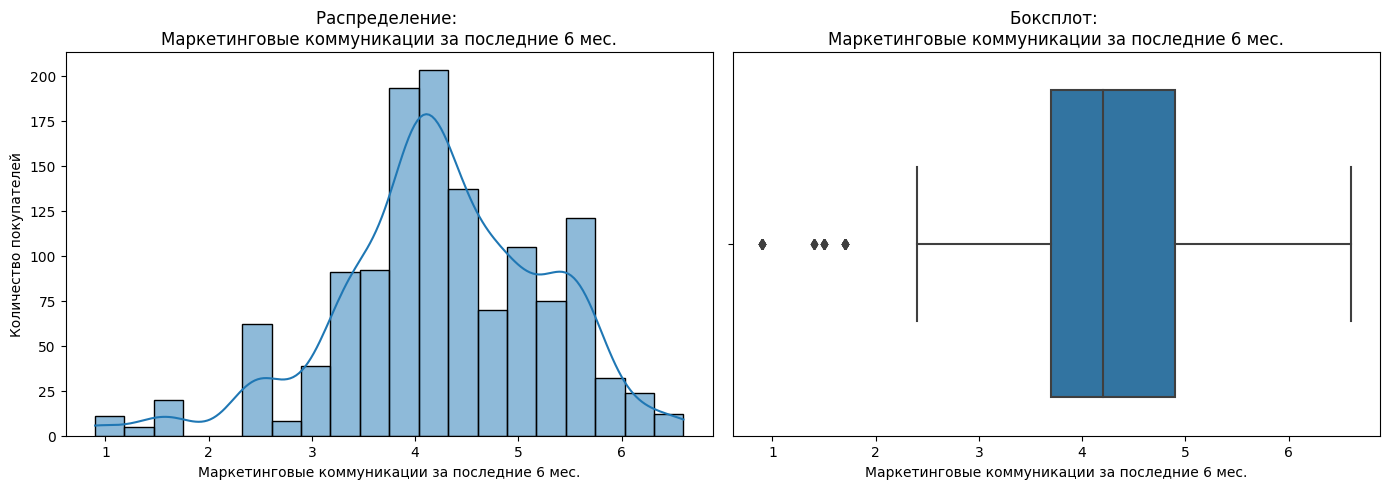

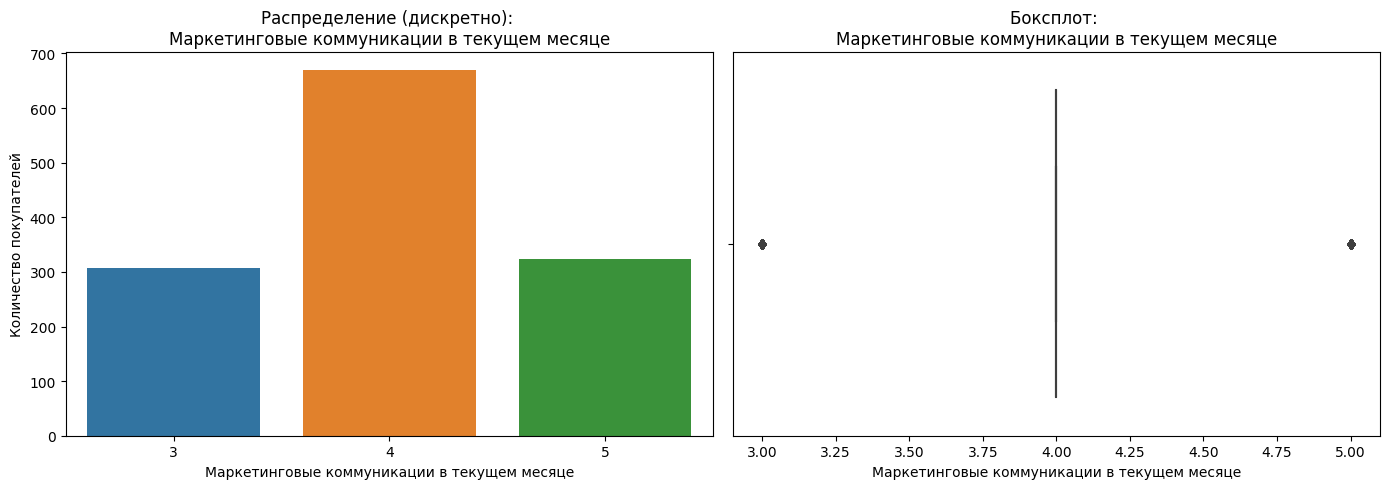

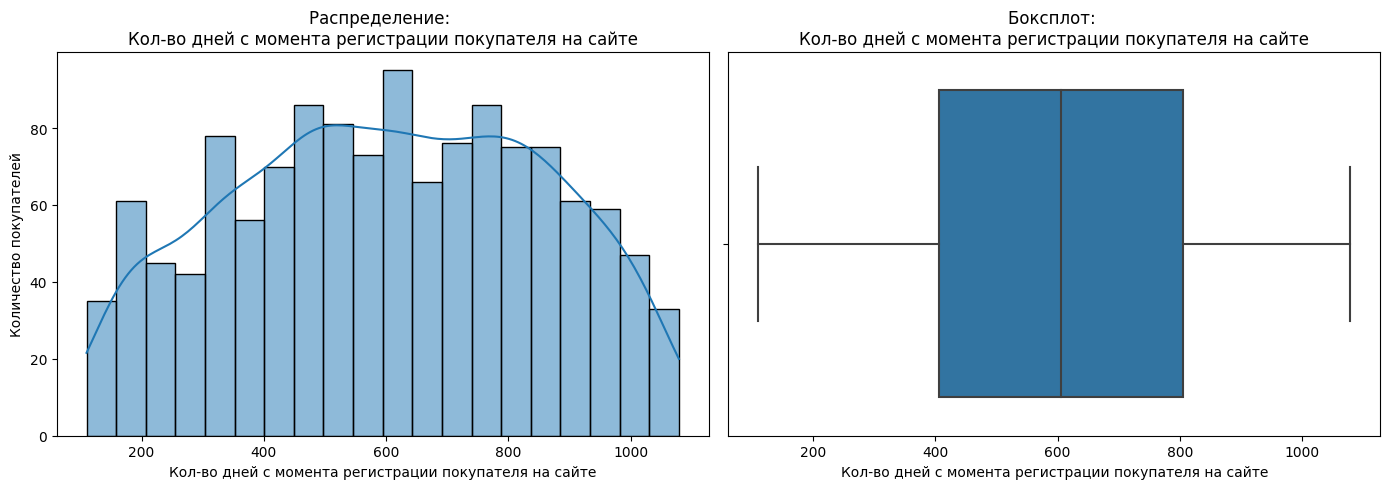

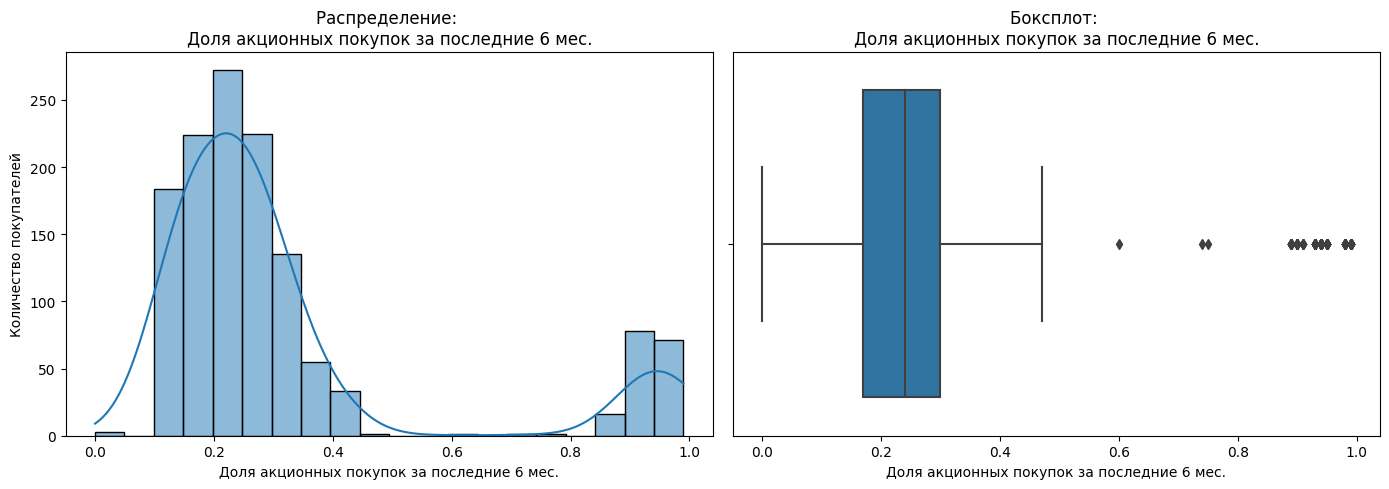

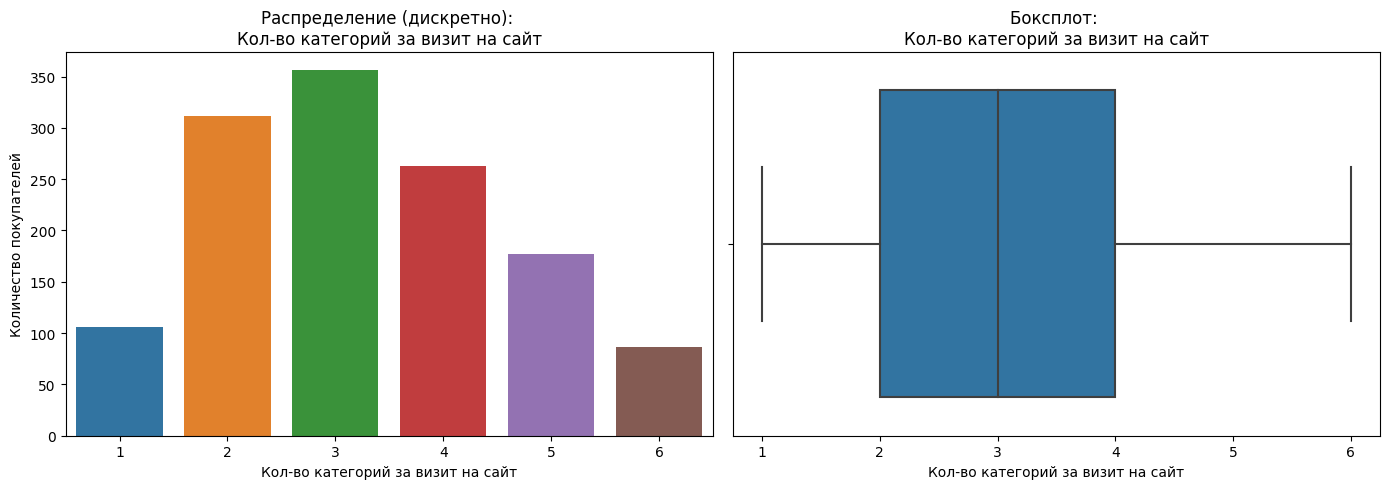

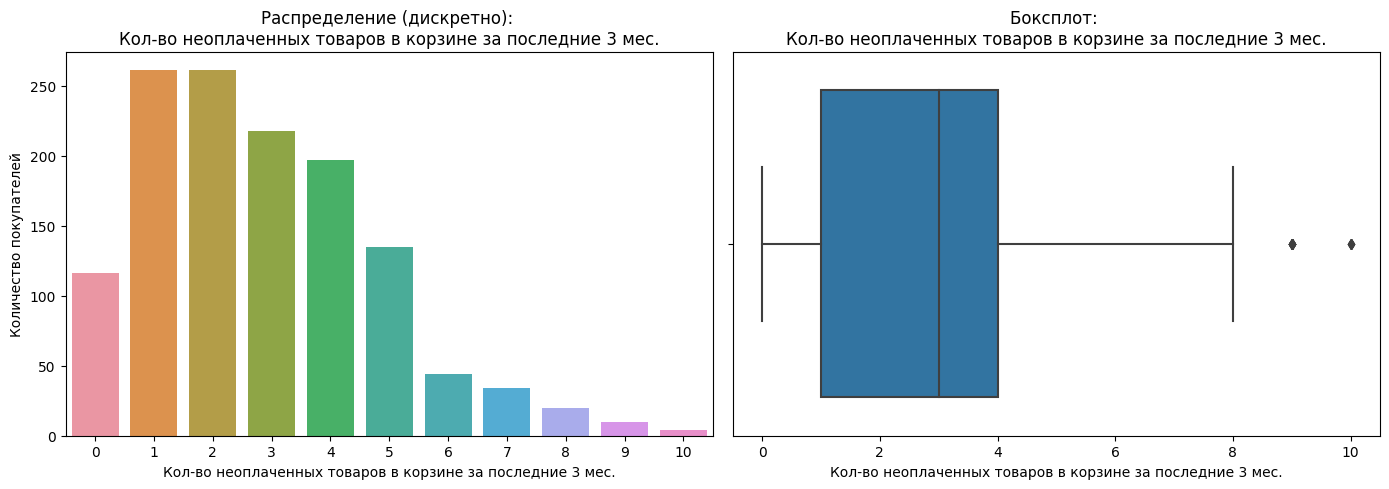

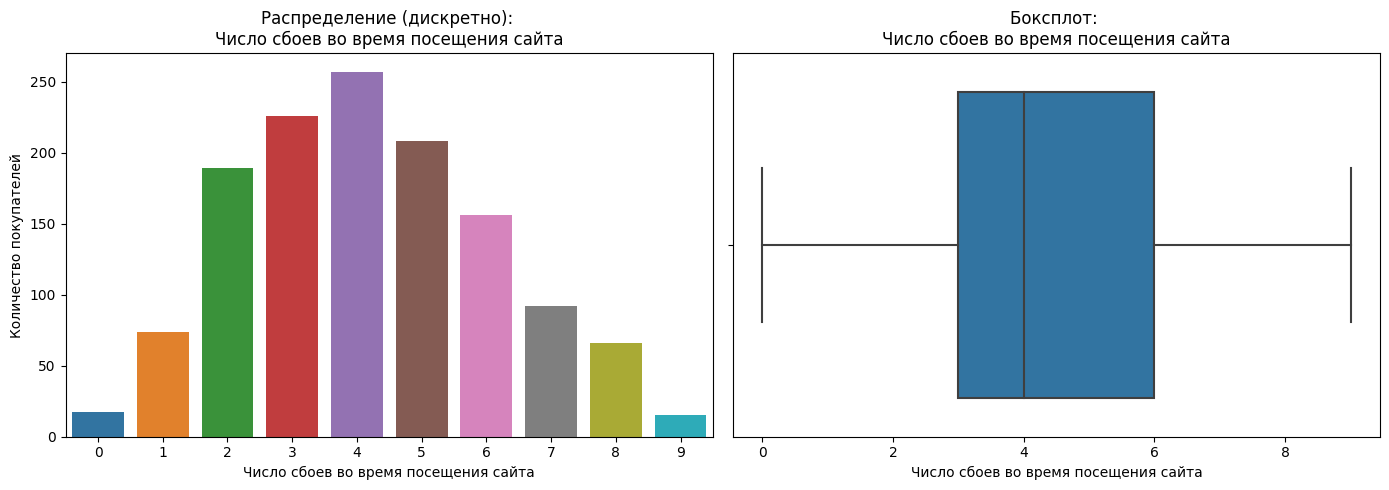

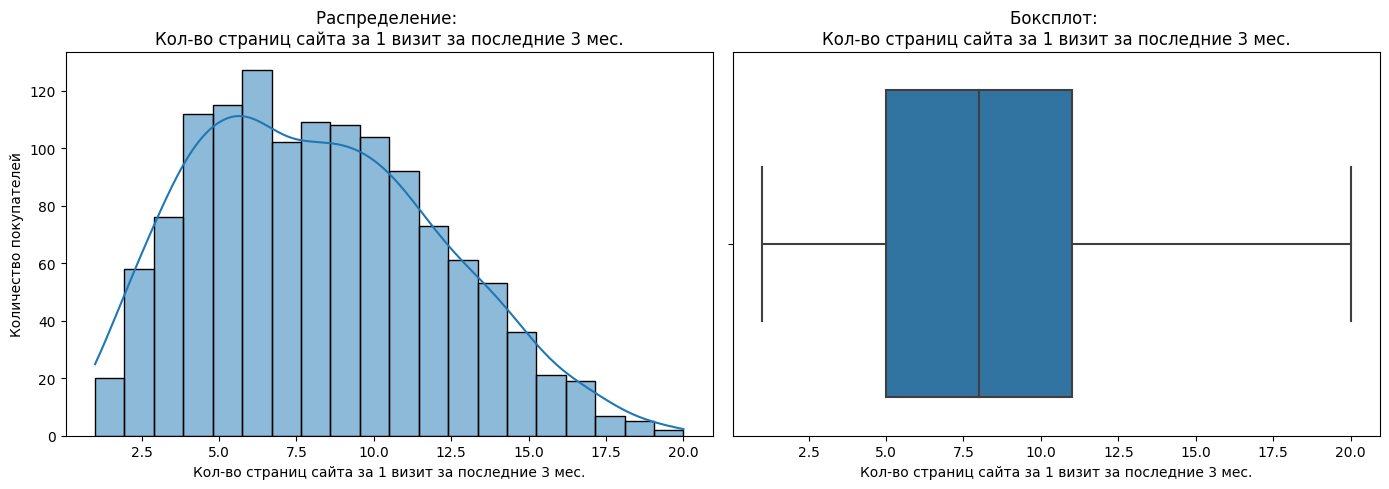

In [39]:
# Функция: является ли признак дискретным (в т.ч. float со всеми целыми значениями)
def is_discrete_feature(series, threshold=15):
    return (
        series.nunique() < threshold and
        (is_integer_dtype(series) or series.dropna().apply(float.is_integer).all())
    )

# Словарь читаемых названий
axis_labels = {
    'market_activ_6_month': 'Маркетинговые коммуникации за последние 6 мес.',
    'market_activ_now_month': 'Маркетинговые коммуникации в текущем месяце',
    'reg_days': 'Кол-во дней с момента регистрации покупателя на сайте',
    'promo_purch_share': 'Доля акционных покупок за последние 6 мес.',
    'avg_cat_per_visit': 'Кол-во категорий за визит на сайт',
    'unpaid_prod_qtr': 'Кол-во неоплаченных товаров в корзине за последние 3 мес.',
    'service_error': 'Число сбоев во время посещения сайта',
    'pages_per_visit': 'Кол-во страниц сайта за 1 визит за последние 3 мес.'
}

# Выбор числовых признаков (кроме id)
num_cols_market_file = market_file.select_dtypes(include='number').columns.drop('id')

for col in num_cols_market_file:
    label = axis_labels.get(col, col)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if is_discrete_feature(market_file[col]):
        sns.countplot(x=market_file[col], ax=axes[0])
        axes[0].set_title(f'Распределение (дискретно): \n{label}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Количество покупателей')
    else:
        sns.histplot(market_file[col], bins=20, kde=True, ax=axes[0])
        axes[0].set_title(f'Распределение: \n{label}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Количество покупателей')

    sns.boxplot(x=market_file[col], ax=axes[1])
    axes[1].set_title(f'Боксплот: \n{label}')
    axes[1].set_xlabel(label)

    plt.tight_layout()
    plt.show()


Так же проверим на нормальность распределения с помощью статистического теста Шапиро–Уилка.

In [40]:
# Отбираем числовые признаки (кроме id, если он есть)
num_cols = market_file.select_dtypes(include='number').columns.drop('id', errors='ignore')

# Проверка тестом Шапиро–Уилка
for col in num_cols:
    stat, p = shapiro(market_file[col])
    print(f"{col}: p-value = {p:.5f} → {'нормальное распределение' if p > 0.05 else 'НЕ нормальное распределение'}")

market_activ_6_month: p-value = 0.00000 → НЕ нормальное распределение
market_activ_now_month: p-value = 0.00000 → НЕ нормальное распределение
reg_days: p-value = 0.00000 → НЕ нормальное распределение
promo_purch_share: p-value = 0.00000 → НЕ нормальное распределение
avg_cat_per_visit: p-value = 0.00000 → НЕ нормальное распределение
unpaid_prod_qtr: p-value = 0.00000 → НЕ нормальное распределение
service_error: p-value = 0.00000 → НЕ нормальное распределение
pages_per_visit: p-value = 0.00000 → НЕ нормальное распределение


1. `market_activ_6_month`         
Тип: количественный, дискретный        
Распределение: асимметричное, с выбросами              
Вывод: отражает активность пользователя в течение полугода. Подходит для модели, однако желательно нормализовать/преобразовать или рассмотреть биннинг.            

2. `market_activ_now_month`           
Тип: количественный, дискретный             
Распределение: почти симметричное, но с коротким диапазоном          
Вывод: полезный индикатор текущей активности. Подходит для модели.              

3. `reg_days`              
Тип: количественный (время регистрации), целое            
Распределение: смещено вправо, пик на малых значениях            
Вывод: отражает "возраст" клиента, потенциально влияет на лояльность. Используем в модели.             

4. `promo_purch_share`            
Тип: количественный (доля), непрерывный            
Распределение: равномерное/слегка U-образное, есть выбросы          
Вывод: критически важный признак поведения. Используется без изменений.             

5. `avg_cat_per_visit`          
Тип: количественный, дискретный           
Распределение: слегка асимметричное, мультимодальное            
Вывод: хорошо разделяет пользователей по интересу к ассортименту. Используем.            

6. `unpaid_prod_qtr`            
Тип: количественный, дискретный          
Распределение: смещено, возможны выбросы            
Вывод: может сигнализировать о проблемах с оплатой. Важно в модели.           

7. `service_error`             
Тип: количественный (счёт ошибок), дискретный    
Распределение: умеренно симметричное           
Вывод: важный индикатор пользовательского опыта. Оставляем в модели.           

8. `pages_per_visit`             
Тип: количественный, дискретный            
Распределение: лёгкий положительный сдвиг            
Вывод: характеризует глубину вовлечённости. Один из ключевых признаков. Используем.             

9. `minutes_on_site_last_month` / `minutes_on_site_now`            
Тип: количественные, непрерывные         
Распределение: с хвостами        
Вывод: описывают поведенческие метрики. Высокая важность. Возможно лог-преобразование для модели.        

10. `revenue_now`, `revenue_last_month`, `revenue_last_last_month`             
Тип: количественные, непрерывные           
Распределение: сильная положительная асимметрия, выбросы          
Вывод: важны, но требуют лог-преобразования или биннинга.            

Вывод          
Большинство признаков пригодны для использования в модели.         
Для признаков с асимметричным распределением (особенно revenue_*, unpaid_prod_qtr, reg_days) желательно применить логарифмическое преобразование или разбиение на категории (биннинг).
Признаки с выбросами требуют масштабирования.
Все признаки содержат полезную информацию и могут использоваться при обучении моделей после корректной подготовки.

In [41]:
market_money.describe()

,id,revenue
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


В данных столбца `revenue` аномальное значение max.

In [42]:
market_money[market_money['revenue'] > 9000]

,id,period,revenue
98,215380,текущий месяц,106862.2


Запись с аномальным значением всего одна. Считаю что ее следует удалить, так как она может сильно скашивает распределение и может повлиять на качество модели.

In [43]:
market_money.shape

(3900, 3)

In [44]:
market_money = market_money.query('revenue < 9000')
market_money.shape

(3899, 3)

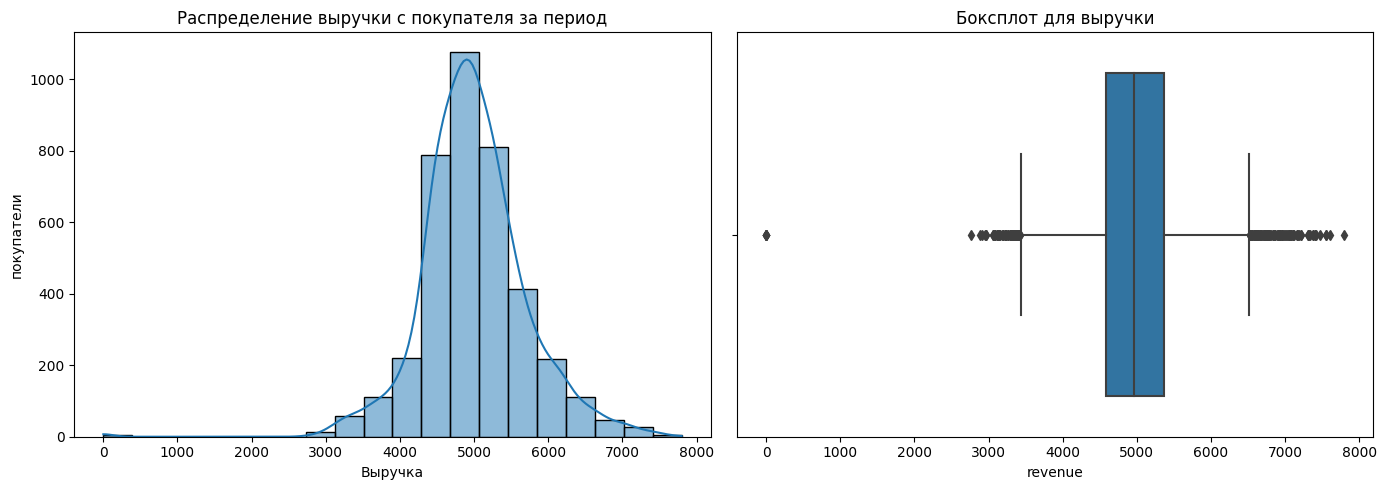

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(market_money['revenue'], bins=20, kde=True, ax=axes[0])
axes[0].set_title(f'Распределение выручки с покупателя за период')
axes[0].set_xlabel('Выручка')
axes[0].set_ylabel('покупатели')
    
sns.boxplot(x=market_money['revenue'], ax=axes[1])
axes[1].set_title(f'Боксплот для выручки')
    
plt.tight_layout()
plt.show()

`revenue` (выручка за период).     
Форма распределения: симметричное c хвостом.   
Особенности: Плотная концентрация значений в центральной части распределения.

Боксплот показывает равномерное распределение с умеренным числом выбросов по краям, но ярко выраженные экстремальные выбросы удалены. Распределение стало гораздо более сбалансированным.

Вывод:
Отличный кандидат для использования в модели напрямую.
Трансформации не требуются, так как распределение стабильно и без перекосов.

In [46]:
market_time.describe()

,id,minutes_on_site
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


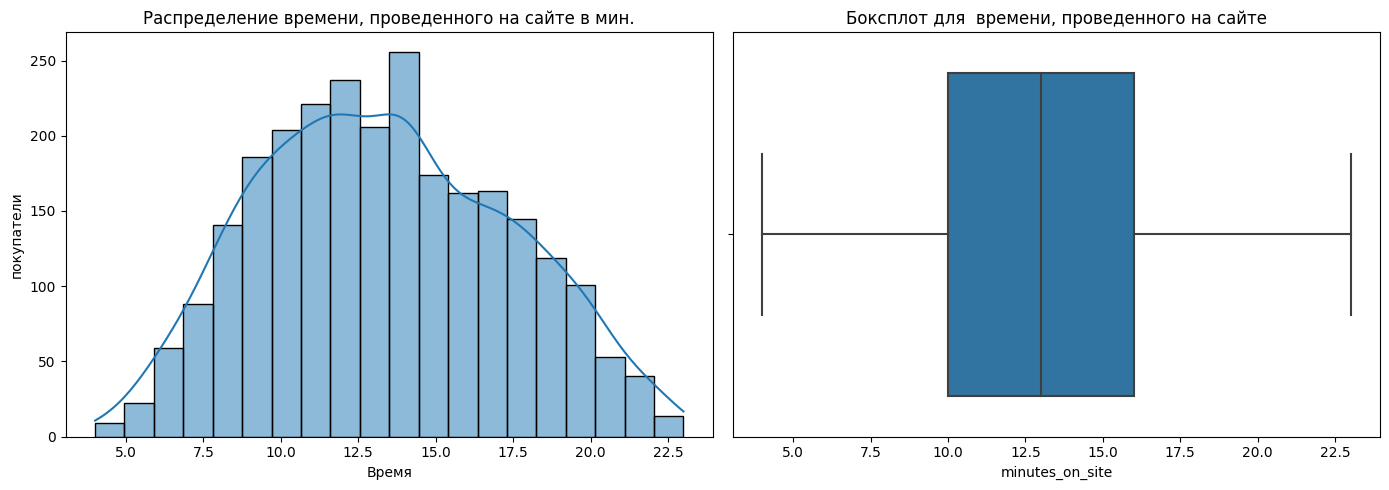

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(market_time['minutes_on_site'], bins=20, kde=True, ax=axes[0])
axes[0].set_title(f'Распределение времени, проведенного на сайте в мин.')
axes[0].set_xlabel('Время')
axes[0].set_ylabel('покупатели')
    
sns.boxplot(x=market_time['minutes_on_site'], ax=axes[1])
axes[1].set_title(f'Боксплот для  времени, проведенного на сайте')
    
plt.tight_layout()
plt.show()

`minutes_on_site` (время на сайте за период, в минутах)
Форма распределения: Близкое к нормальному, с лёгким сдвигом влево (более высокая плотность в центральных и правых значениях).

Особенности: Плавное, хорошо сбалансированное распределение без выраженных выбросов.
Значения равномерно распределены, экстремальные точки отсутствуют.
Боксплот подтверждает отсутствие крайних значений и сжатие распределения в середине.

Вывод:
Признак подходит для использования напрямую в модели.
Трансформации не требуются, так как распределение стабильное и не имеет перекосов.

Может быть полезен как индикатор вовлечённости пользователя в работу с сайтом.

In [48]:
money.describe()

,id,avg_profit_3_month
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Среднемесячная прибыль варьируется от 0.86 до 7.43, а среднее около 4.0.
При этом максимальная выручка ранее достигала 7800 рублей.

Если прибыль единицами сравнима с выручкой, то 4 рубля прибыли в месяц с клиента выглядит нереалистично мало.
Более логично предположить, что в данной таблице единицы измерения — тысячи рублей, так как это лучше всего согласуется с масштабом выручки и диапазоном значений.

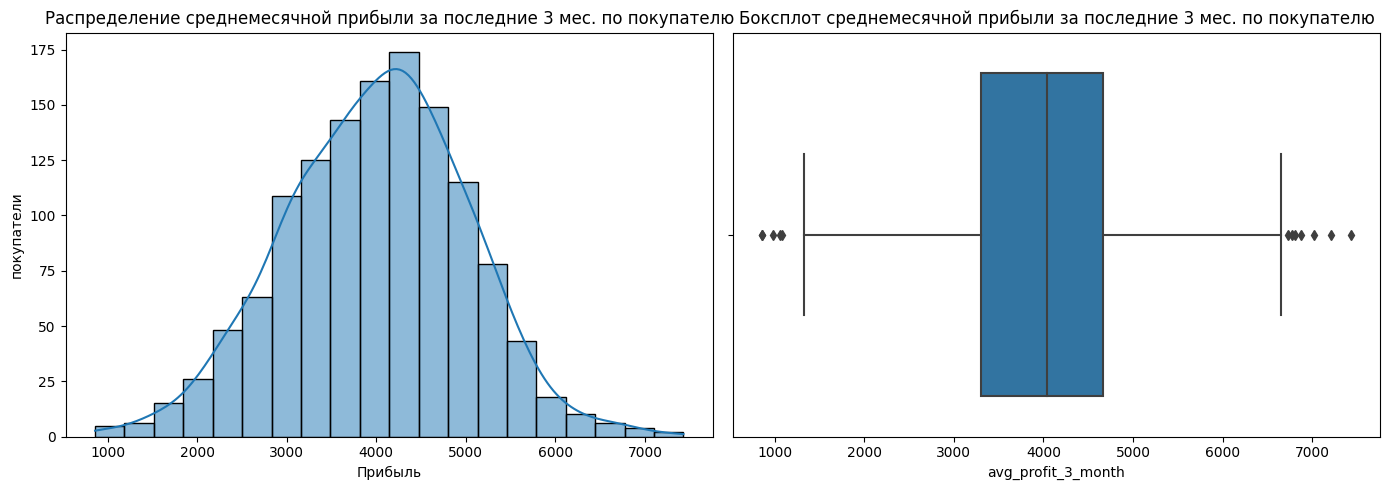

In [49]:
money['avg_profit_3_month'] *= 1000

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(money['avg_profit_3_month'], bins=20, kde=True, ax=axes[0])
axes[0].set_title(f'Распределение среднемесячной прибыли за последние 3 мес. по покупателю')
axes[0].set_xlabel('Прибыль')
axes[0].set_ylabel('покупатели')
    
sns.boxplot(x=money['avg_profit_3_month'], ax=axes[1])
axes[1].set_title(f'Боксплот среднемесячной прибыли за последние 3 мес. по покупателю')
    
plt.tight_layout()
plt.show()

`avg_profit_3_month` (среднемесячная прибыль с покупателя за последние 3 месяца, в рублях)   
Форма распределения: Почти нормальное, симметричное распределение с умеренными хвостами.        
Особенности: Основная масса значений лежит в диапазоне 3300–4700 руб.      
Медиана — 4045 руб., что совпадает с визуальным центром распределения.   
Есть немного нижних и верхних выбросов (от 860 до 7430 руб.), но они не искажают картину.     

Вывод:
Признак полностью пригоден для прямого использования в моделях.       
Трансформации не требуются.       
Подходит для сегментации клиентов по уровню прибыльности.       

#####  Статистический анализ категориальных признаков¶

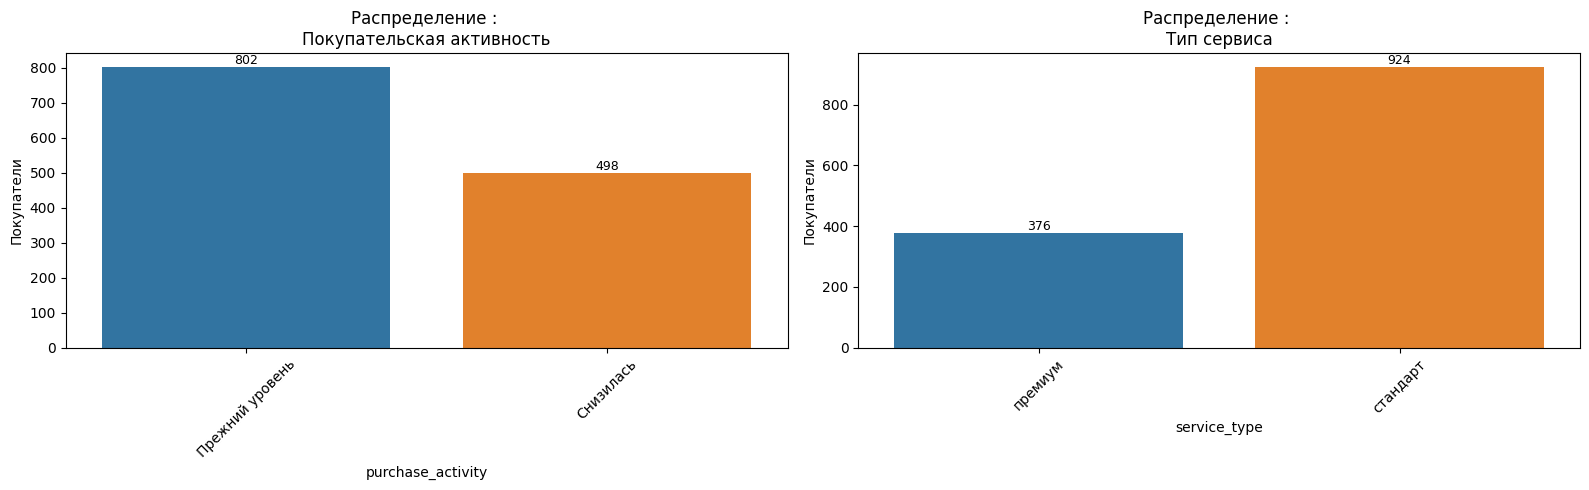

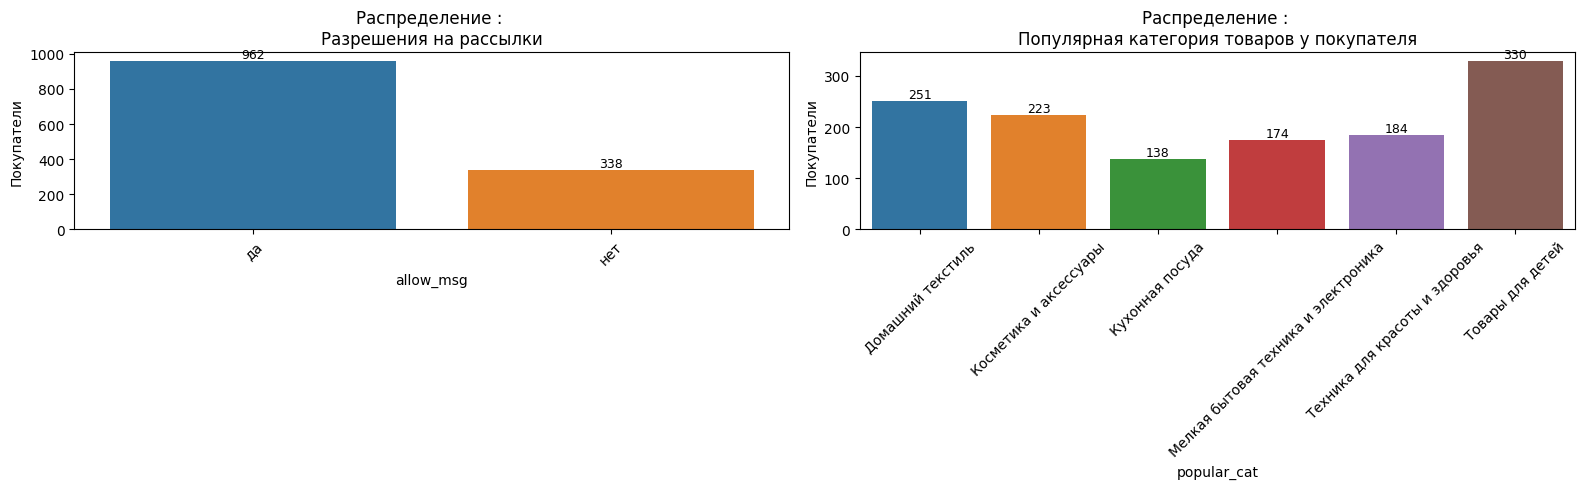

In [50]:
# Словарь читаемых названий
axis_labels_1 = {
    'purchase_activity': 'Покупательская активность',
    'service_type': 'Тип сервиса',
    'allow_msg': 'Разрешения на рассылки',
    'popular_cat': 'Популярная категория товаров у покупателя'
}
    
cols = list(cat_cols_market_file)
for i in range(0, len(cols), 2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    for j in range(2):
        if i + j < len(cols):
            col = cols[i + j]
            label = axis_labels_1.get(col, col)
            # Построение графика
            ax = sns.countplot(x=market_file[col], ax=axes[j])
            axes[j].set_xticklabels(axes[j].get_xticklabels(), rotation=45)
            axes[j].set_ylabel('Покупатели')
            axes[j].set_title(f'Распределение : \n{label}')
            
            # Добавление значений над столбиками
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height}', 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

Покупательская активность (`purchase_activity`)
Наблюдается умеренный дисбаланс классов: класс «Прежний уровень» встречается примерно в 1.6 раза чаще, чем «Снизилась». Большинство клиентов снизили активность.

Тип сервиса (`service_type`)
Вывод: Большинство клиентов пользуются премиум-сервисом.

Разрешение на маркетинг (`allow_msg`)
Бóльшая часть клиентов разрешила получать маркетинговые предложения.

Популярная категория (`popular_cat`)
Есть как лидирующие, так и менее популярные категории — хорошая основа для сегментации.

Общие выводы:
Наблюдается умеренный дисбаланс классов: класс «Прежний уровень» встречается примерно в 1.6 раза чаще, чем «Снизилась».
Это важно учитывать при обучении модели машинного обучения, чтобы не переобучиться на преобладающий класс и не терять чувствительность к классу "Снизилась", который особенно важен для бизнеса — это пользователи, которых нужно вернуть.

Таким образом, для оценки качества модели будем использовать метрики, чувствительные к дисбалансу: recall, f1, roc_auc.
Так же применим class_weight='balanced' или методы пересемплирования (например, SMOTE).

Преобладание премиум-сегмента — может повлиять на выбор стратегии удержания.
Большинство клиентов разрешают маркетинг, что открывает возможности для работы с ними.
Разные категории товаров позволяют сегментировать аудиторию по предпочтениям.

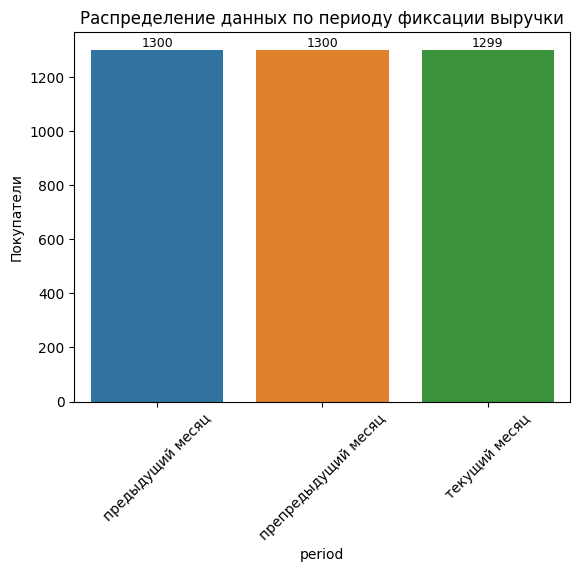

In [51]:
ax = sns.countplot(x=market_money['period'])
plt.xticks(rotation=45)
plt.ylabel('Покупатели')
plt.title('Распределение данных по периоду фиксации выручки')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)
plt.show()

`period` (период фиксации выручки)

Данные равномерно покрывают все три периода, что хорошо для анализа динамики.
Потери данных незначительны (всего одна запись отсутствует в последнем периоде, которая была удалена как аномалия).
Выборка сбалансирована по периодам, это позволяет проводить сравнительный анализ без перекоса.

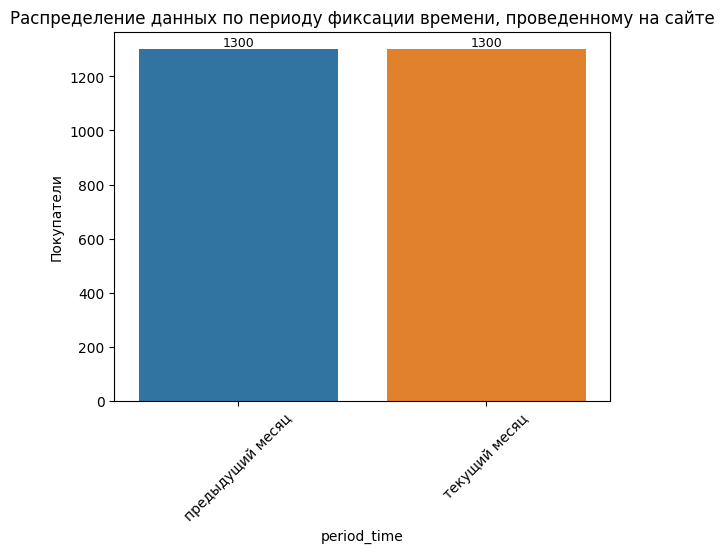

In [52]:
ax = sns.countplot(x=market_time['period_time'])
plt.xticks(rotation=45)
plt.ylabel('Покупатели')
plt.title('Распределение данных по периоду фиксации времени, проведенному на сайте')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)
plt.show()

`period_time` (период фиксации времени на сайте)

Данные полностью сбалансированы по двум периодам, без пропусков.
Это позволяет надёжно сравнивать поведение пользователей между этими двумя временными интервалами.

##### Отбор клиентов с покупательской активностью

Так как нас не интересуют "пустые" клиенты, которые не совершали никаких покупок, нам необходимо отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 

In [53]:
inactive_customers = market_money.loc[market_money['revenue'] == 0, 'id'].unique()
inactive_customers

array([215348, 215357, 215359], dtype=int64)

In [54]:
print('\nmarket_file -', len(market_file), 
      '\nmarket_time -', len(market_time), 
      '\nmarket_money -', len(market_money), 
      '\nmoney -', len(money))


market_file - 1300 
market_time - 2600 
market_money - 3899 
money - 1300


У нас три таких клиента, фильтруем все таблицы, чтоб избавиться от "пустых" строк

In [55]:
market_file = market_file[~market_file['id'].isin(inactive_customers)]
market_time = market_time[~market_time['id'].isin(inactive_customers)]
market_money = market_money[~market_money['id'].isin(inactive_customers)]
money = money[~money['id'].isin(inactive_customers)]

print('\nmarket_file -', len(market_file), 
      '\nmarket_time -', len(market_time), 
      '\nmarket_money -', len(market_money), 
      '\nmoney -', len(money))


market_file - 1297 
market_time - 2594 
market_money - 3890 
money - 1297


Данные в таблице `market_file` и `money` уменьшились на 3 позиции.   
В таблице `market_time` - на 6, так как по каждому клиенту таблица содержит 2 периода. Соответственно по трем клиентам минус 6 записей.   
В таблице `market_money` - на 9, так как по каждому клиенту таблица содержит 3 периода. Соответственно по трем клиентам минус 9 записей.     

##### Выводы исследовательского анализа

По результатам исследовательского анализа данных были изучены распределения всех количественных и категориальных признаков. В числовом признаке revenue (выручка за период) была обнаружена аномалия — экстремально высокое значение, которое было удалено. После этого распределение выручки стало нормальным и пригодным для использования в моделировании.
Так же произведен отбор только тех клиентов, кто соверших хотябы одну полкупку за 3 месяца. Исключение "нулевых" клиентов уменьшает шум в данных и повышает точность предсказания.

Требуют дополнительных манипуляций:
`promo_purch_share` — доля акционных покупок, рекомендуется биннинг или категориальное кодирование,
`unpaid_prod_qtr` — количество неоплаченных товаров в корзине, рекомендуется логарифмирование,

Категориальные признаки готовы к использованию после кодирования.

Дополнительные наблюдения:
Целевая переменная (`purchase_activity`) несбалансирована — большинство клиентов снизили активность, что важно учитывать при выборе метрик качества модели.

Преобладание премиум-сегмента (`service_type`) — это может повлиять на выбор стратегии удержания клиентов.

Большинство клиентов разрешили маркетинг (`allow_msg`), что создаёт возможности для персонализированных коммуникаций.

Разнообразие категорий товаров (`popular_cat`) позволяет сегментировать аудиторию по предпочтениям и разрабатывать целевые предложения.

Таким образом, все признаки проверены, очищены и подготовлены к следующему этапу — построению модели и разработке персонализированных рекомендаций.

#### Объединение таблиц

Объединим таблицы `market_file`, `market_money`, `market_time`. Данные о прибыли из файла `money` при моделировании нам не понадобятся. 
Изначально таблицы `market_money` и`market_time` содержат по несколько записей на клиента по периодам, поэтому подход к объединению таких таблиц:

`market_file` — основная таблица с по 1 записи на клиента.
`market_money` — по 3 записи на клиента, надо развернуть в ширину по периодам.
`market_time` — по 2 записи на клиента, тоже развернуть в ширину по периодам.

Таким образом, должна получиться одна общая таблица с 1297 строками и 18 столбцами.

In [56]:
# Разворот market_money с переименованием
market_money_wide = market_money.pivot(index='id', columns='period', values='revenue')
market_money_wide = market_money_wide.rename(columns={
    'текущий месяц': 'revenue_now',
    'предыдущий месяц': 'revenue_last_month',
    'препредыдущий месяц': 'revenue_last_last_month'
})
market_money_wide.reset_index(inplace=True)

# Разворот market_time с переименованием
market_time_wide = market_time.pivot(index='id', columns='period_time', values='minutes_on_site')
market_time_wide = market_time_wide.rename(columns={
    'текущий месяц': 'minutes_on_site_now',
    'предыдущий месяц': 'minutes_on_site_last_month'
})
market_time_wide.reset_index(inplace=True)

# Объединение всех таблиц
market_total = market_file.merge(market_money_wide, on='id', how='left')
market_total = market_total.merge(market_time_wide, on='id', how='left')
market_total.head()

,id,purchase_activity,service_type,allow_msg,market_activ_6_month,market_activ_now_month,reg_days,promo_purch_share,popular_cat,avg_cat_per_visit,unpaid_prod_qtr,service_error,pages_per_visit,revenue_last_month,revenue_last_last_month,revenue_now,minutes_on_site_last_month,minutes_on_site_now
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [57]:
market_total.shape

(1297, 18)

Размер новой таблицы соответствует запланированному.

#### Корреляционный анализ

##### Матрица корреляции

Изучим взаимосвязь между признаками. Для этого рассчитаем коэффициенты корреляции между всеми признаками с помощью матрицы корреляции phik

In [58]:
# Исключаем столбец 'id' из данных
market_no_id = market_total.drop(columns='id')

# Вычисляем корреляционную матрицу без 'id'
correlation_matrix = phik_matrix(
    market_no_id,
    interval_cols=[
        'market_activ_6_month',
        'reg_days', 
        'promo_purch_share',  
        'revenue_last_month',
        'revenue_last_last_month',
        'revenue_now',
        'pages_per_visit',
        'minutes_on_site_last_month',
        'minutes_on_site_now'
    ]
).round(2)

correlation_matrix

,purchase_activity,service_type,allow_msg,market_activ_6_month,market_activ_now_month,reg_days,promo_purch_share,popular_cat,avg_cat_per_visit,unpaid_prod_qtr,service_error,pages_per_visit,revenue_last_month,revenue_last_last_month,revenue_now,minutes_on_site_last_month,minutes_on_site_now
purchase_activity,1.00,0.13,0.00,0.55,0.00,0.10,0.51,0.30,0.54,0.40,0.22,0.75,0.23,0.50,0.20,0.69,0.58
service_type,0.13,1.00,0.29,0.09,0.04,0.40,0.03,0.07,0.19,0.11,0.08,0.10,0.00,0.07,0.12,0.13,0.00
allow_msg,0.00,0.29,1.00,0.00,0.05,0.25,0.02,0.07,0.07,0.16,0.02,0.04,0.08,0.00,0.06,0.04,0.00
market_activ_6_month,0.55,0.09,0.00,1.00,0.08,0.00,0.28,0.15,0.21,0.22,0.15,0.39,0.15,0.31,0.04,0.36,0.33
market_activ_now_month,0.00,0.04,0.05,0.08,1.00,0.17,0.00,0.14,0.25,0.14,0.12,0.00,0.05,0.00,0.00,0.11,0.06
reg_days,0.10,0.40,0.25,0.00,0.17,1.00,0.00,0.00,0.19,0.13,0.17,0.12,0.13,0.11,0.15,0.02,0.10
promo_purch_share,0.51,0.03,0.02,0.28,0.00,0.00,1.00,0.12,0.20,0.25,0.00,0.31,0.07,0.23,0.07,0.26,0.25
popular_cat,0.30,0.07,0.07,0.15,0.14,0.00,0.12,1.00,0.23,0.25,0.00,0.16,0.25,0.05,0.24,0.20,0.09
avg_cat_per_visit,0.54,0.19,0.07,0.21,0.25,0.19,0.20,0.23,1.00,0.34,0.07,0.26,0.10,0.18,0.09,0.16,0.18
unpaid_prod_qtr,0.40,0.11,0.16,0.22,0.14,0.13,0.25,0.25,0.34,1.00,0.00,0.27,0.19,0.19,0.17,0.20,0.17


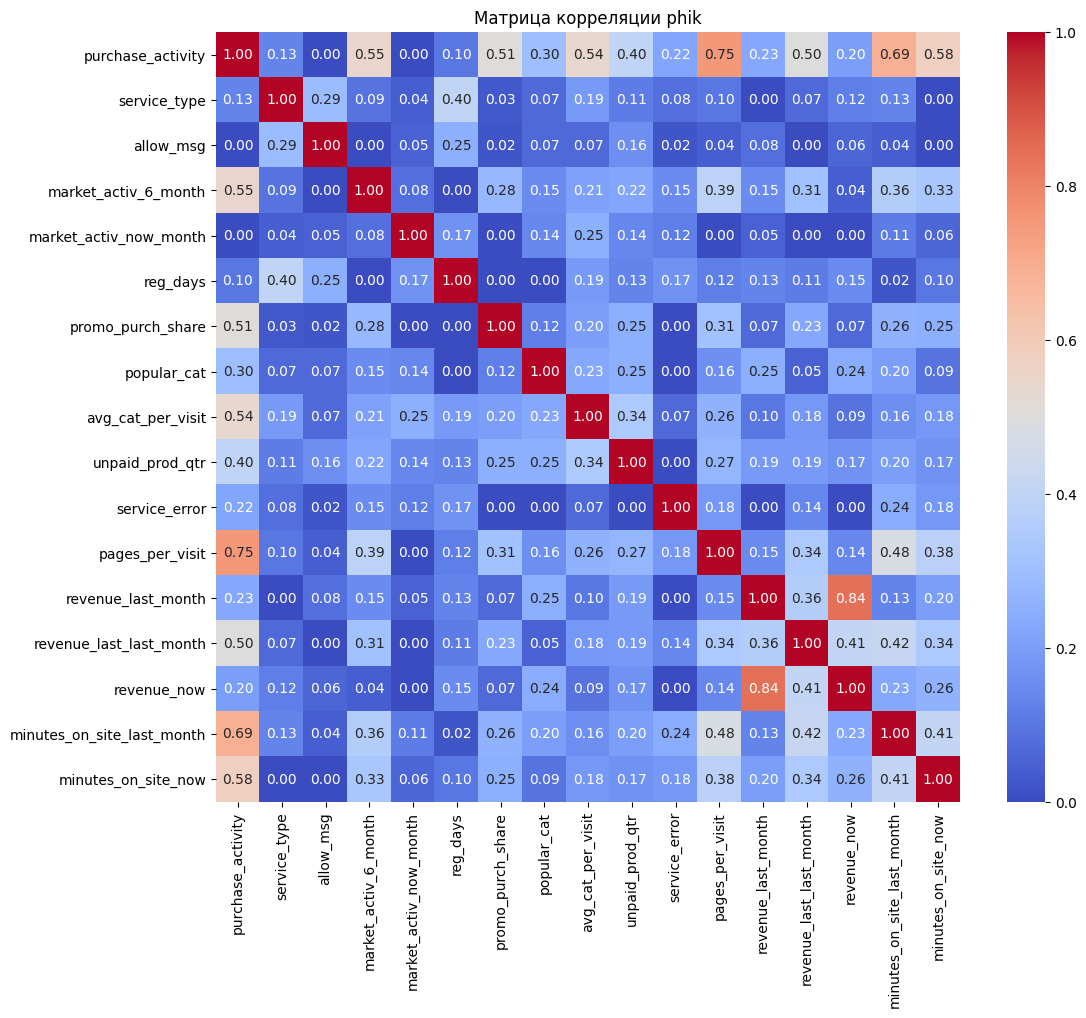

In [59]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Матрица корреляции phik")
plt.show()

Связи с целевым признаком `purchase_activity`

1. Сильно связаны:
`pages_per_visit` (0.75)
`minutes_on_site_last_month` (0.69)
`revenue_last_month` (0.61)
`revenue_last_last_month` (0.50)
`minutes_on_site_now` (0.58)
Эти признаки имеют высокий потенциал как полезные предикторы.

2. Между собой связаны:
`revenue_last_month` и `revenue_now` (0.84)
`revenue_last_last_month` и `revenue_now` (0.41)
Можно оставить один агрегированный признак выручки либо проверить влияние всех трёх на переобучение.

3. `market_activ_6_month` и `market_activ_now_month`:
Низкая связь (0.08), оставить оба, так как они отражают разный временной контекст.

4. Слабосвязанные признаки (phi < 0.4):
`service_type`, `allow_msg`, `popular_cat`, `avg_cat_per_visit`, `unpaid_prod_qtr`, `service_error`
Эти признаки можно оставить, они дополняют поведенческий профиль клиента.

Возможная оптимизация:
Сделать один агрегированный признак `total_revenue_last_3_months` вместо трёх отдельных revenue_*.

##### Анализ взаимосвязий целевого признака с входными признаками

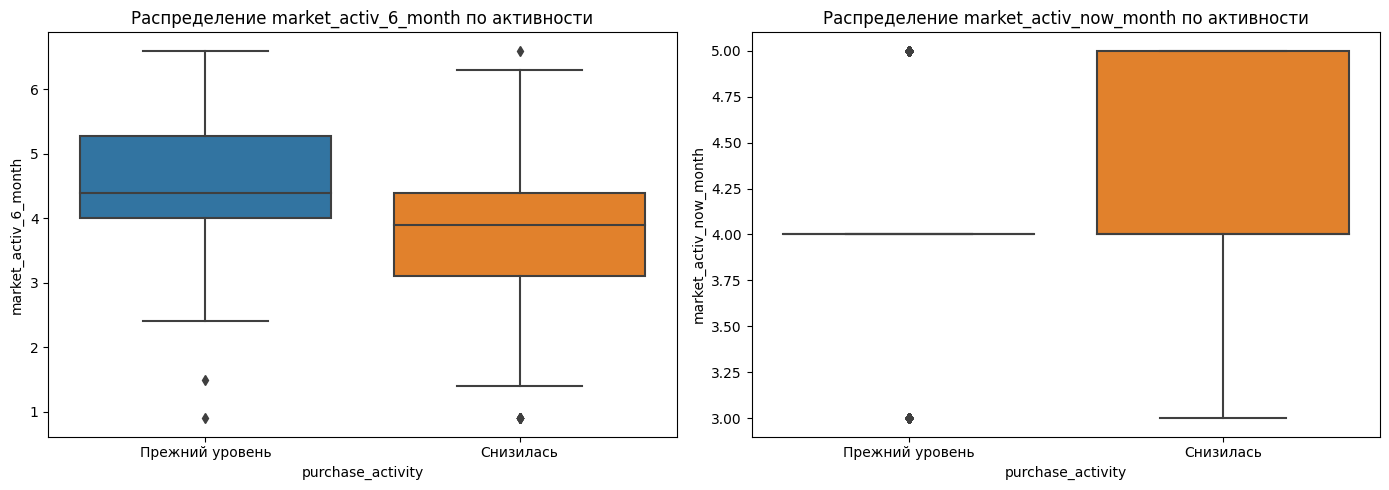

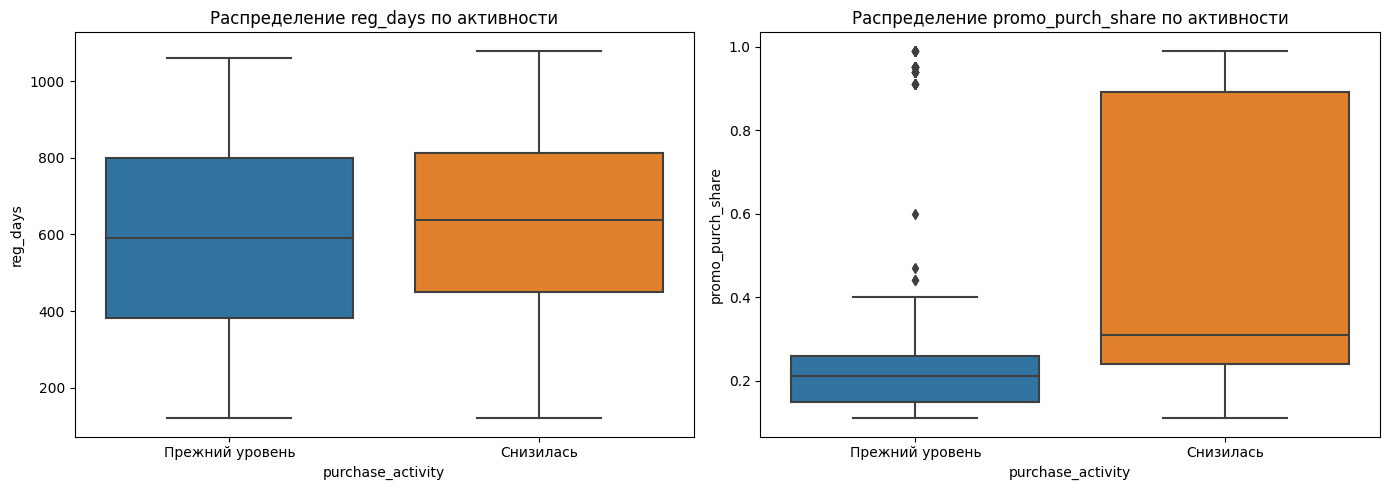

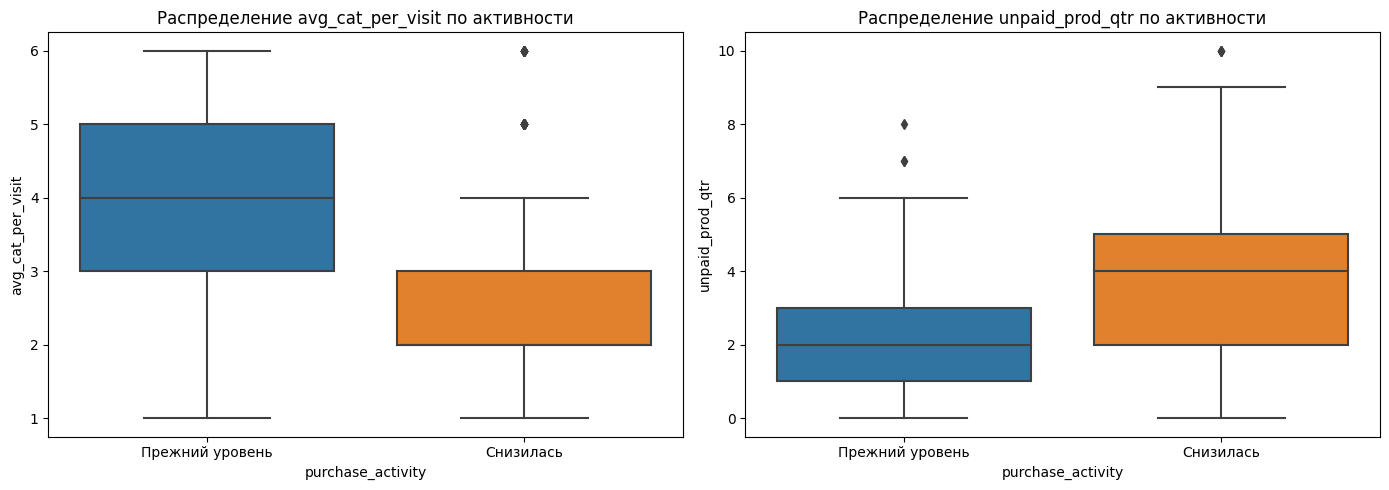

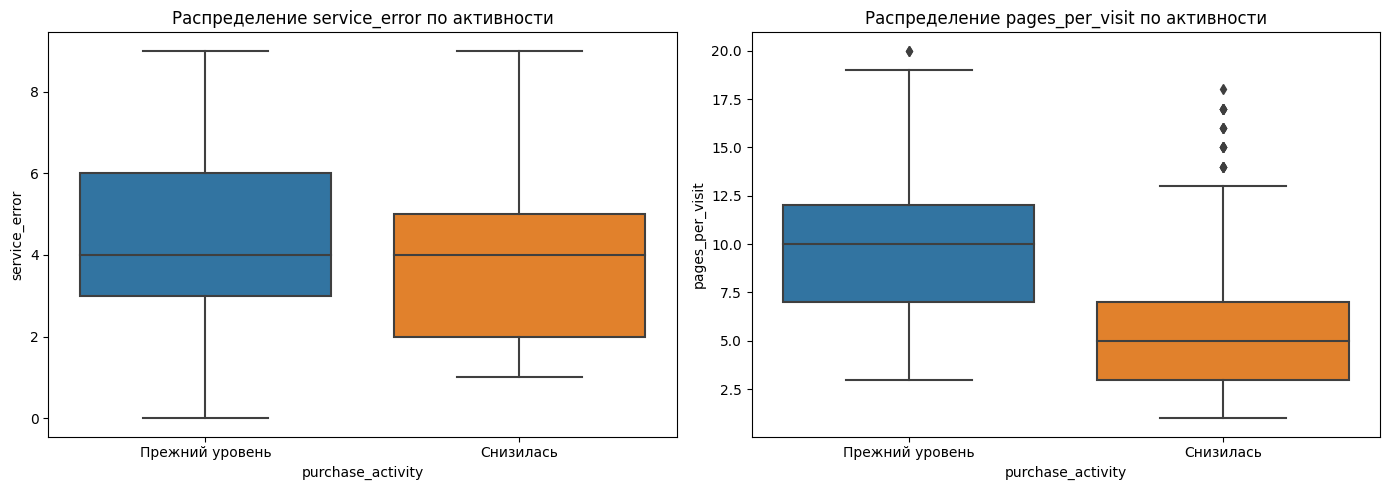

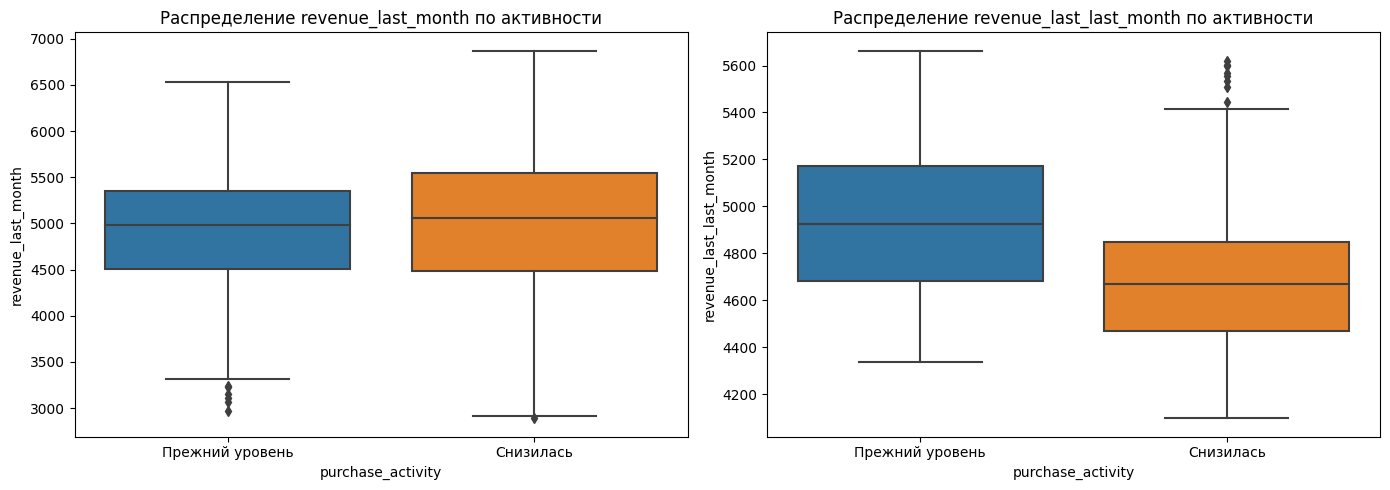

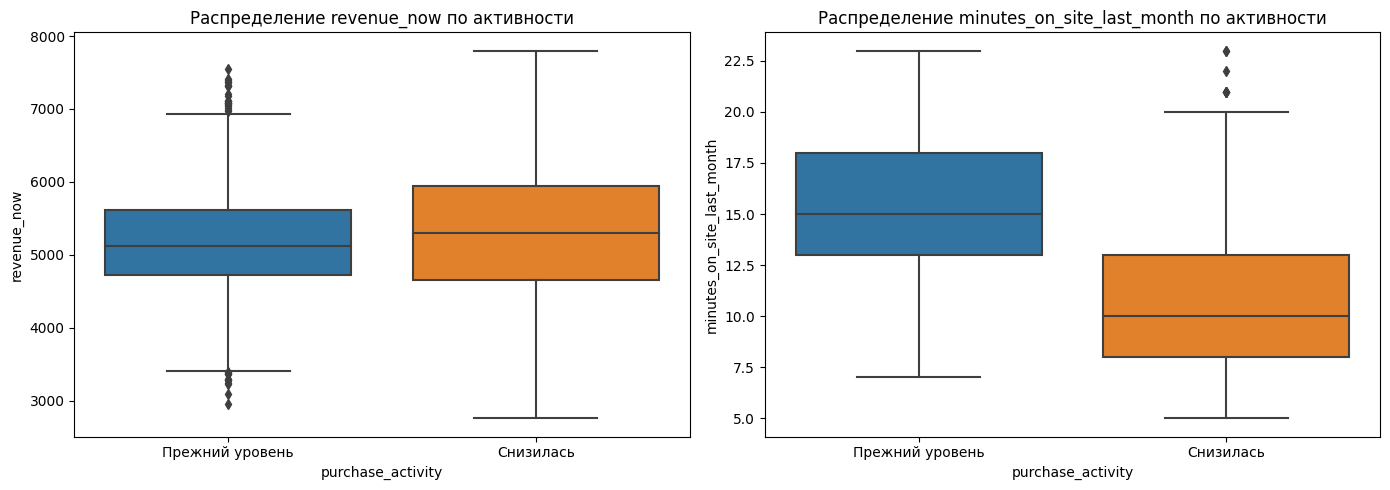

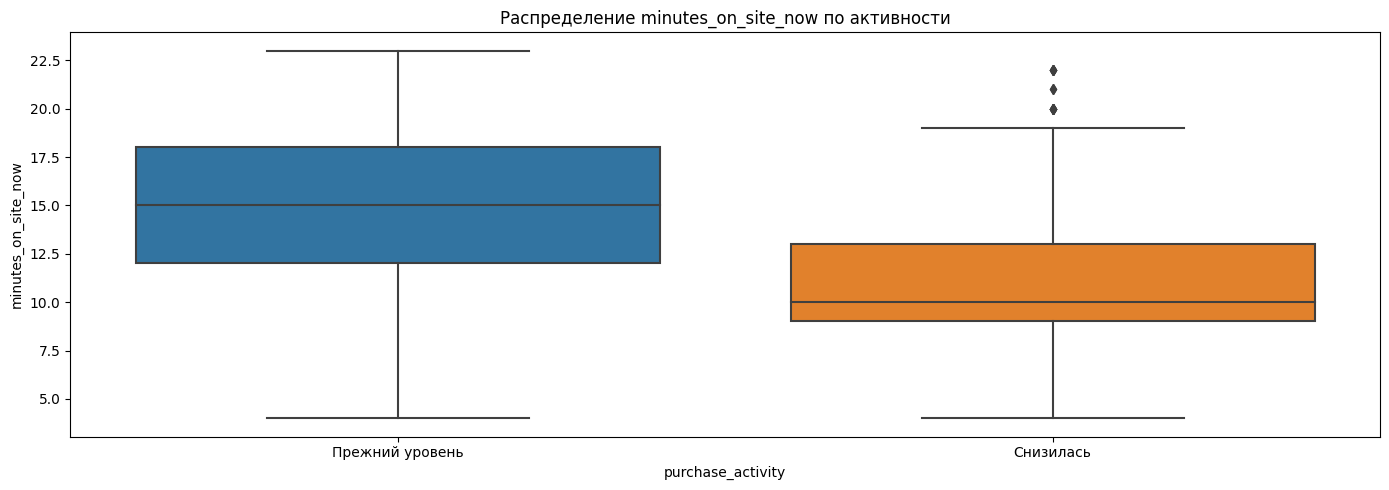

In [60]:
num_cols = market_total.select_dtypes(include=['int64', 'float64']).columns.drop('id')

cols = list(num_cols)

for i in range(0, len(cols), 2):
    n_subplots = min(2, len(cols) - i)  # определяем сколько графиков в ряду: 1 или 2
    fig, axes = plt.subplots(1, n_subplots, figsize=(14, 5))
    
    # Приведение к списку, если один график
    if n_subplots == 1:
        axes = [axes]
    
    for j in range(n_subplots):
        sns.boxplot(x='purchase_activity', y=cols[i + j], data=market_total, ax=axes[j])
        axes[j].set_title(f'Распределение {cols[i + j]} по активности')
    
    plt.tight_layout()
    plt.show()

Регистрационный стаж (`reg_days`).     
Незначительное отличие между группами.   
Признак слабо разделяет классы, малополезен для модели.   

Доля акционных покупок (`promo_purch_share`).   
Различия выражены слабо, форма распределения схожа.           
Может остаться в модели, но важность под вопросом.             

Маркетинговая активность за 6 месяцев и текущий месяц (`market_activ_6_month`, `market_activ_now_month`).            
Незначительные отличия, активность клиентов не показывает явного разделения.            
Возможно, стоит оставить только один, например, `market_activ_6_month`.            
 
Поведение на сайте (страницы, категории).             
`avg_cat_per_visit` и `pages_per_visit` хорошо разделяют классы — заметно различаются медианы.             
Эти признаки стоит оставить.            

Неоплаченные товары (`unpaid_prod_qtr`).            
Хорошо различает группы.             
Полезный признак.           

Ошибки сервиса (`service_error`).               
Различий практически нет.             
Малополезный признак, можно исключить.           

Выручка по месяцам (`revenue_last_month`, `revenue_last_last_month`, `revenue_now`).              
Выраженное различие между активными и неактивными.            
Все признаки информативны, но возможна мультиколлинеарность.             

Время на сайте (`minutes_on_site_last_month`, `minutes_on_site_now`).             
Выраженное различие между группами.              
Полезные признаки, стоит оставить оба.             

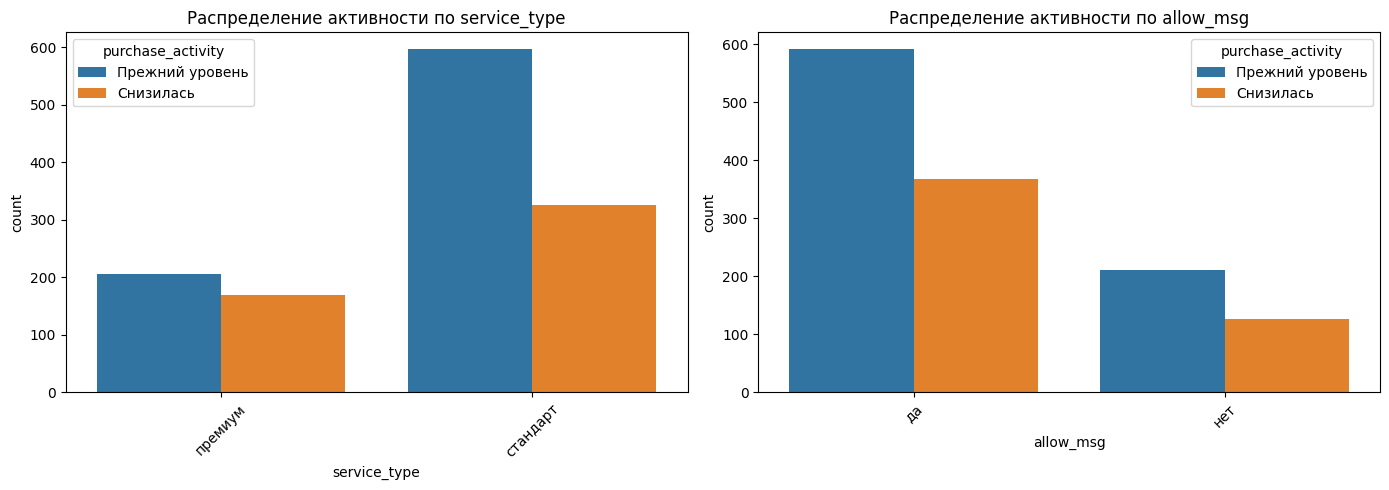

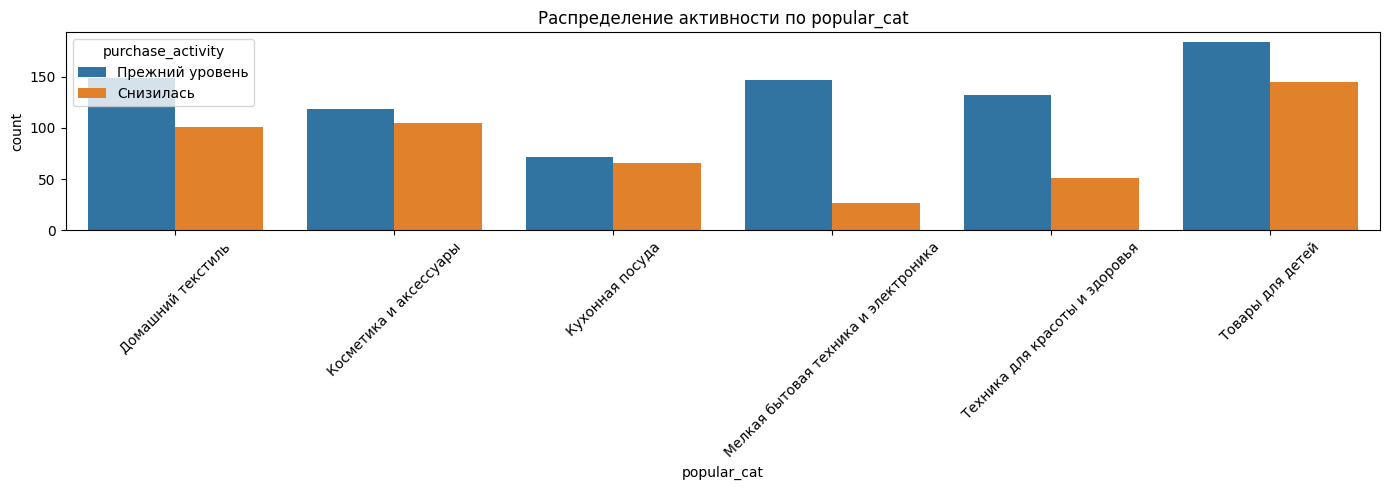

In [61]:
cat_cols = market_total.select_dtypes(include=['object', 'category']).columns.drop('purchase_activity')

cols = list(cat_cols)

for i in range(0, len(cols), 2):
    n_subplots = min(2, len(cols) - i)
    fig, axes = plt.subplots(1, n_subplots, figsize=(14, 5))
    
    if n_subplots == 1:
        axes = [axes]
    
    for j in range(n_subplots):
        sns.countplot(x=cols[i + j], hue='purchase_activity', data=market_total, ax=axes[j])
        axes[j].set_title(f'Распределение активности по {cols[i + j]}')
        axes[j].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

Тип сервиса (`service_type`).           
У премиум-клиентов чаще наблюдается снижение активности.           
Полезный для сегментации.       

Разрешение на маркетинг (`allow_msg`).         
Незначительные различия.         
Полезность под вопросом.          

Популярные категории (`popular_cat`).          
Явные различия по группам.        
Полезный для построения модели.              

##### Мультиколлинеарность

Выявлена высокая взаимосвязь между:   
`revenue_last_month`, `revenue_last_last_month`, `revenue_now`.          
Рекомендуется агрегировать в один признак, например, суммарная выручка за 3 месяца.         

`market_activ_6_month` и `market_activ_now_month`.          
Почти дублируют друг друга. Рекомендуется оставить один (например, `market_activ_6_month`).   

Время на сайте в разные месяцы (`minutes_on_site_last_month`, `minutes_on_site_now`).      
Хотя связаны, но различают группы по-разному, можно оставить оба.     

##### Выводы по корреляционному анализу

В результате корреляционного анализа мультиколлинеарности между признаками не обнаружена.

Признак `market_activ_now_month` и `market_activ_6_month` почти дублируют друг друга. Можно оставить призщнак маркетинговой активности за 6 мес, так как он отражает долгосрочную маркетинговую активность и сохраняет больше полезной информации.

Остались признаки с умеренной или слабой корреляцией, такие как:        
`promo_purch_share`         
`service_error`         
`allow_msg`       

На данном этапе удалять признаки не буду. Для уточнения их реального влияния на модель необходимо применить метод SHAP.

#### Использование пайплайнов

Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберем как минимум один гиперпараметр. 

Для DecisionTreeClassifier - значения max_depth от 2 до 4 и max_features от 2 до 4 для предотвращения переобучения.
Для KNeighborsClassifier - количество соседей от 2 до 4, чтобы найти баланс между стабильностью и локальностью.
Для LogisticRegression - коэффициенты регуляризации C от 1 до 4 для оценки влияния жёсткой и слабой регуляризации.
Для SVC - различные скейлеры для обеспечения корректного масштабирования данных.

У нас несбалансированные классы, поэтому метрика ROC-AUC — лучший выбор.
Класс "Снизилась" встречается реже, чем "Прежний уровень".
Метрики вроде accuracy будут завышать результат за счёт доминирующего класса.
ROC-AUC оценивает качество разделения классов,
не завися от их соотношения. Показывает, насколько модель отличает один класс от другого,
независимо от выбранного порога. Поддерживается для большинства задач бинарной классификации.

Наша цель — находить клиентов, у которых снизилась активность.
Пропустить таких клиентов — хуже, чем ошибочно отнести активного к неактивным.
Это говорит в пользу Recall или F1-score.

Таким образом, оставляем ROC-AUC как основную метрику для подбора модели, потому что она устойчива к дисбалансу.
Оценим Recall и F1-score на тесте, чтобы понять, насколько модель действительно ловит целевой класс.

In [62]:
# Кодирование таргета через LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(market_total['purchase_activity'])

# Разделение данных
X = market_total.drop(['purchase_activity', 'id'], axis=1)
y = y_encoded

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Проверка размерностей после разбиения
print(f'Размер X_train: {X_train.shape[0]} строк × {X_train.shape[1]} признаков')
print(f'Размер X_test : {X_test.shape[0]} строк × {X_test.shape[1]} признаков')
print(f'Размер y_train: {y_train.shape[0]}')
print(f'Размер y_test : {y_test.shape[0]}')

# Определение признаков
ohe_columns = ['allow_msg', 'popular_cat']
ord_columns = ['service_type']
num_columns = ['market_activ_6_month', 'reg_days', 'promo_purch_share',
       'avg_cat_per_visit', 'unpaid_prod_qtr', 'service_error',
       'pages_per_visit', 'minutes_on_site_last_month', 'minutes_on_site_now',
       'revenue_last_month', 'revenue_last_last_month', 'revenue_now', 'market_activ_now_month']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['премиум', 'стандарт']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(1, 20),
        'models__max_features': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            class_weight='balanced'
        )],
        'models__penalty': ['l1', 'l2'],
        'models__C':  [0.01, 0.1, 1, 10],
        'models__max_iter': [1000, 2000, 3000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

model_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

model_search.fit(X_train, y_train)

# Вывод лучшей модели и параметров
print('Лучшая модель и её параметры:\n\n', model_search.best_estimator_)
print('Метрика ROC-AUC на тренировочной выборке:', model_search.best_score_)

# Оценка на тестовой выборке
best_model_pipeline = model_search.best_estimator_
X_test_prepared = best_model_pipeline.named_steps['preprocessor'].transform(X_test)
fitted_model = best_model_pipeline.named_steps['models']

# Предсказания классов
y_test_pred = model_search.predict(X_test)
y_test_pred_binary = y_test_pred
y_test_binary = y_test

# Получение вероятностей
if hasattr(fitted_model, 'predict_proba'):
    y_test_proba = model_search.predict_proba(X_test)[:, 1]
else:
    y_test_proba = model_search.decision_function(X_test)

# Вычисление метрик
roc_auc = roc_auc_score(y_test_binary, y_test_proba)
recall = recall_score(y_test_binary, y_test_pred_binary)
f1 = f1_score(y_test_binary, y_test_pred_binary)

print('Метрика ROC-AUC на тестовой выборке:', roc_auc)
print('Recall на тестовой выборке:', recall)
print('F1-score на тестовой выборке:', f1)

Размер X_train: 972 строк × 16 признаков
Размер X_test : 325 строк × 16 признаков
Размер y_train: 972
Размер y_test : 325
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['allow_msg', 'popular_cat']),
                                            

В качестве стратегии выбора модели использована вторая рекомендация — единый пайплайн с инструментом подбора гиперпараметров (GridSearchCV).
Все модели и их параметры были объединены в один набор, что позволило автоматически определить лучшую модель и оптимальные настройки на основе метрики ROC-AUC.

Лучшая модель — DecisionTreeClassifier
Глубина дерева (max_depth=5) — хорошо контролирует переобучение.
Максимум признаков (max_features=8) — ограничивает сложность, повышает обобщаемость.
Балансировка классов (class_weight='balanced') — помогает бороться с дисбалансом.

Предобработка
Числовые признаки — без масштабирования (passthrough). Значит, модели хватило их исходного масштаба.

ROC-AUC на обучающей выборке - 0.85 - Модель хорошо разделяет классы на тренировке.      
ROC-AUC на тестовой выборке - 0.88 - Модель обобщает на новых данных.            
Recall - 0.73 - Находит ~73% клиентов со снижением активности.           
F1-score - 0.76 - Хороший баланс между точностью и полнотой.          

#### Анализ важности признаков

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.

In [63]:
importances = fitted_model.feature_importances_
feature_names = best_model_pipeline.named_steps['preprocessor'].get_feature_names_out()


pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)


,feature,importance
7,num__market_activ_6_month,0.059423
9,num__promo_purch_share,0.056613
13,num__pages_per_visit,0.051867
17,num__revenue_last_last_month,0.050498
15,num__minutes_on_site_now,0.025266
11,num__unpaid_prod_qtr,0.015274
10,num__avg_cat_per_visit,0.009441
12,num__service_error,0.003831
3,ohe__popular_cat_Мелкая бытовая техника и элек...,0.001576
18,num__revenue_now,0.000000


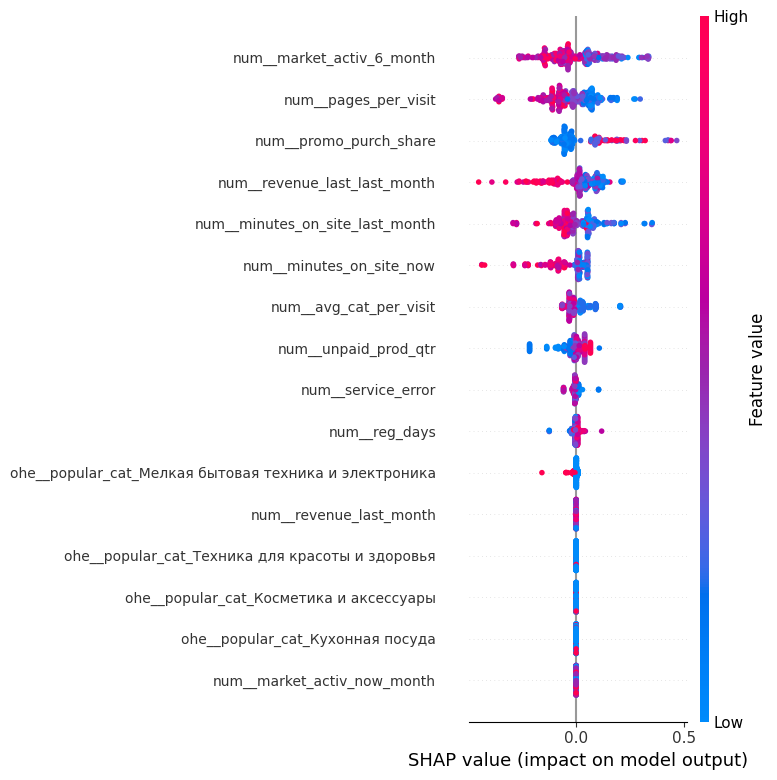

In [64]:
model = best_model_pipeline.named_steps['models']
feature_names = best_model_pipeline.named_steps['preprocessor'].get_feature_names_out()
explainer      = shap.TreeExplainer(model)

explainer   = shap.TreeExplainer(model)
shap_values = explainer(X_test_prepared)        

# берём слой для класса «Снизилась» (индекс 1) …
class1_vals = shap_values.values[:, :, 1]       
class1_base = shap_values.base_values[:, 1]    

# и переупаковываем в Explanation
class1_expl = shap.Explanation(
    values        = class1_vals,
    base_values   = class1_base,
    data          = shap_values.data,
    feature_names = feature_names
)

shap.summary_plot(
    shap_values      = class1_vals,          
    features         = X_test_prepared,
    feature_names    = feature_names,
    max_display      = 16,
    show             = False                 
)

# при желании меняем размер шрифта меток
plt.gca().tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

Наиболее значимые признаки:
`num__market_activ_6_month`
- Активность клиента за последние 6 месяцев.
- Самый значимый фактор: высокая активность уменьшает вероятность снижения покупательской активности.

`num__pages_per_visit`
- Количество страниц за визит.
- Чем больше клиент изучает страницы, тем выше вероятность, что он останется активным.

`num__promo_purch_share`
- Доля промо-покупок.
- Показывает чувствительность к акциям, важный признак для оценки лояльности.

`num__revenue_last_last_month`
- Выручка два месяца назад.
- Важный поведенческий индикатор с отложенным влиянием.

`num__minutes_on_site_last_month` и `num__minutes_on_site_now`
- Время на сайте — как в прошлом месяце, так и сейчас.
- Снижение времени может сигнализировать об убывающем интересе.

Слабо значимые и незначимые признаки:
Категориальные признаки по популярным категориям товаров:
`ohe__popular_cat_...` — почти все имеют нулевую значимость.
Вывод: возможно, текущая категоризация слишком обобщённая или не несёт информативности в разрезе активности.

Признаки `num__revenue_now`, `num__market_activ_now_month`, `ord__service_type`, `allow_msg` — тоже оказались незначимыми.
Возможные причины: слабая вариативность или низкая связь с откликом.

Что можно сделать:
Для моделирования:
Можно исключить признаки с SHAP важностью ≈ 0, чтобы упростить модель и ускорить обучение.

Углубить анализ категориальных признаков: возможно, стоит пересмотреть их группировку.

Использовать инженерию признаков — например, создавать агрегаты: "разница во времени на сайте между месяцами", "тренд выручки" и т.п.

Для бизнеса:
Фокус на удержание тех, у кого снижается активность на сайте или уменьшается число страниц за визит.
Маркетинговые акции — важны для клиентов с высокой долей промо-покупок.
Выстраивать предиктивные стратегии на основе активности за 6 месяцев и времени вовлечения.

#### Сегментация покупателей

8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.
8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
Проведите графическое и аналитическое исследование группы покупателей.
Сделайте предложения по работе с сегментом для увеличения покупательской активности.
8.3 Сделайте выводы о сегментах:
какой сегмент вы взяли для дополнительного исследования,
какие предложения вы сделали и почему.

In [65]:
market_segmentation = market_total.merge(money, on='id')

# Медианная прибыль как порог
median_profit = market_segmentation['avg_profit_3_month'].median()
market_segmentation['high_profit'] = market_segmentation['avg_profit_3_month'] > median_profit

# Сегментация
market_segmentation['segment'] = market_segmentation.apply(lambda row:
    'Упали, но ценные' if row['purchase_activity'] == 'Снизилась' and row['high_profit'] else
    'Ушли и невыгодные' if row['purchase_activity'] == 'Снизилась' else
    'Лояльные и выгодные' if row['high_profit'] else
    'Лояльные, но дешёвые', axis=1)

# Распределение по сегментам
market_segmentation['segment'].value_counts()

Лояльные, но дешёвые    402
Лояльные и выгодные     400
Упали, но ценные        248
Ушли и невыгодные       247
Name: segment, dtype: int64

Распределение покупателей по сегментам:

- 🤝 Лояльные, но дешёвые - 402 - Активны, но приносят небольшую прибыль
- 💎 Лояльные и выгодные - 400 - Активны и приносят хорошую прибыль — идеальные
- ⚠️ Упали, но ценные - 248 - Снизили активность, но потенциально прибыльные
- ❌ Ушли и невыгодные - 247 - Потеряны и при этом невыгодны — низкий приоритет

Целевой сегмент для работы: "Упали, но ценные"
Почему: приносили прибыль, но начали уходить.

Что делать:
Акции на любимые категории (popular_cat)
Возврат через персонализированные рассылки (allow_msg)
Анализ времени на сайте (minutes_on_site_now) — сегментировать ещё тоньше

Отбираем ключевую группу покупателей и визуализируем распределение их поведенческих признаков. Для анализа были отобраны признаки, которые напрямую влияют на пользовательский опыт, легко интерпретируются с точки зрения бизнеса и могут быть объектом изменений (мы можем запустить акцию, улучшить сервис и т.д.):

- `avg_cat_per_visit` Показывает интерес к ассортименту. Если количество категорий снизилось — интерес упал.
- `pages_per_visit` Маркер вовлечённости: меньше страниц — меньше времени/мотивации на выбор.
- `minutes_on_site_now` Время на сайте = прокси-показатель заинтересованности.
- `promo_purch_share` Может указывать на чувствительность к акциям. Ценные клиенты могли «уйти» без скидок.
- `unpaid_prod_qtr` Если растёт — возможно, барьеры в оплате или недовольство. Это снижает доверие.
- `service_error` Проблемы с обслуживанием часто ведут к оттоку. Особенно у платёжеспособных клиентов.

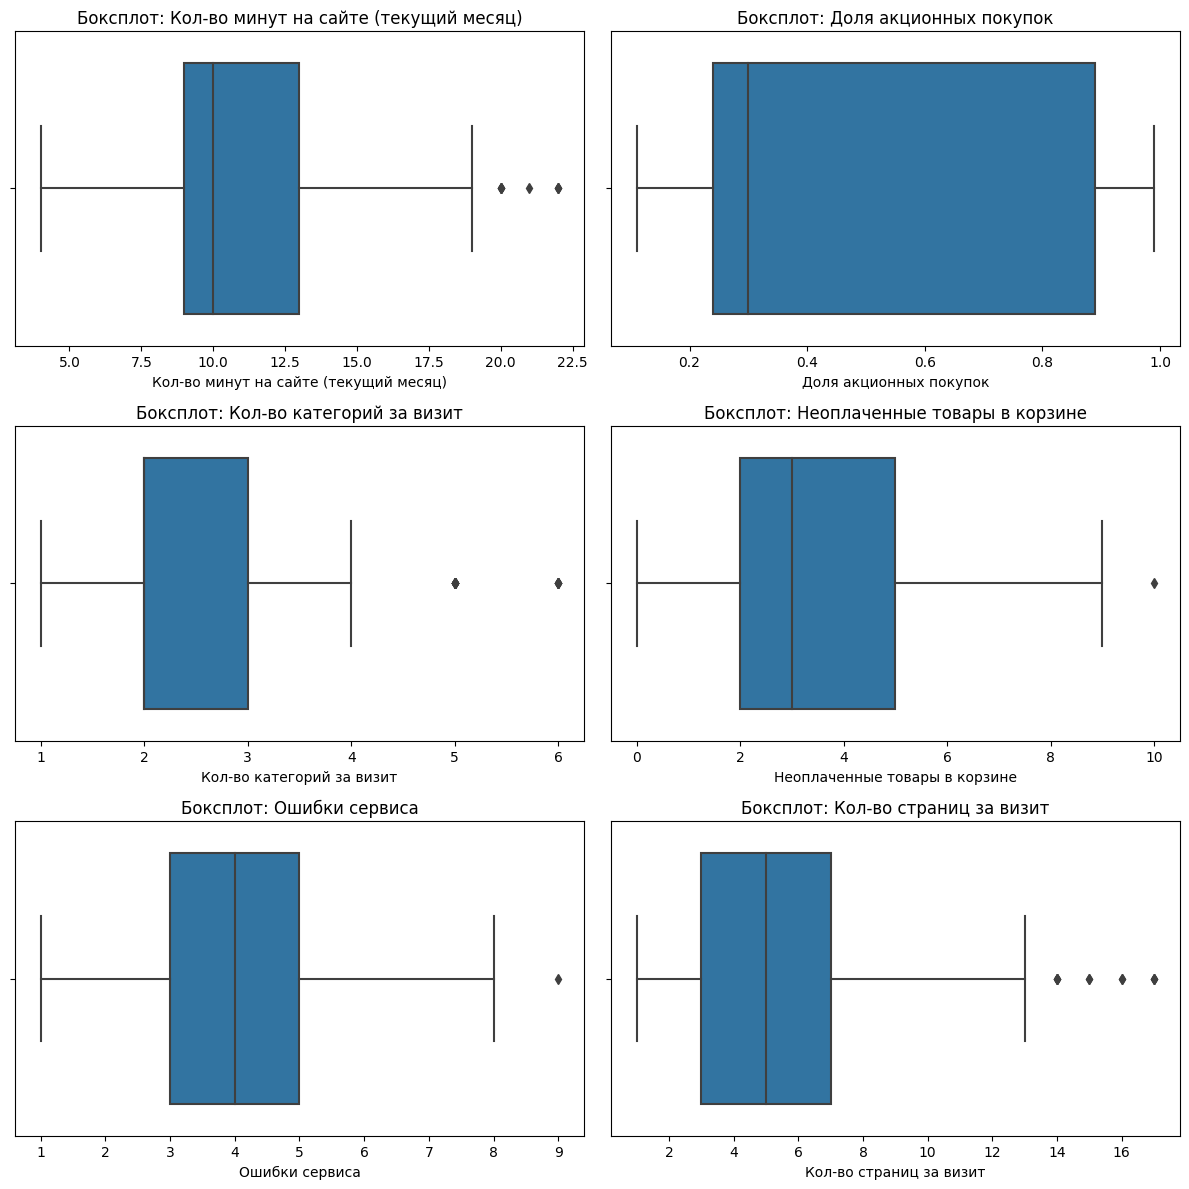

In [70]:
valuable_fallen = market_segmentation[market_segmentation['segment'] == 'Упали, но ценные']

selected_features = {
    'minutes_on_site_now': 'Кол-во минут на сайте (текущий месяц)',
    'promo_purch_share': 'Доля акционных покупок',
    'avg_cat_per_visit': 'Кол-во категорий за визит',
    'unpaid_prod_qtr': 'Неоплаченные товары в корзине',
    'service_error': 'Ошибки сервиса',
    'pages_per_visit': 'Кол-во страниц за визит'
}

n_cols = 2
n_rows = (len(selected_features) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for idx, feat_key in enumerate(selected_features):
    feat_label = selected_features[feat_key]
    sns.boxplot(x=valuable_fallen[feat_key], ax=axes[idx])
    axes[idx].set_title(f'Боксплот: {feat_label}')
    axes[idx].set_xlabel(feat_label)

plt.tight_layout()
plt.show()

- `avg_cat_per_visit` - Посещают разнообразные категории, медиана ≈ 3, но с выбросами до 6.
- `pages_per_visit` - В среднем 5–6 страниц, но много сессий с очень низким просмотром.
- `minutes_on_site_now` - Время сократилось, медиана около 10 минут. Это может говорить об утрате интереса.
- `promo_purch_share` - Активно реагировали на акции (есть клиенты с близкими к 1 значениями).
- `unpaid_prod_qtr` - Некоторые не оплачивают товары. Проблема может отпугивать.
- `service_error` - Много обращений в сервис — показатель неудовлетворённости.

Рекомендации по работе с сегментом:
- Снизить количество ошибок сервиса — возможно, стоит пересмотреть UX сайта или логистику.
- Упростить оплату товаров и предложить поддержку по "висячим" заказам.
- Вовлечение через персонализированные предложения:
- Предложить товары из популярных для них категорий с индивидуальной скидкой.
- Использовать email-кампании с напоминанием о просмотренных товарах, чтобы вернуть интерес.
- Использовать ограниченные по времени акции к тем, кто ранее реагировал на промо. Можно настроить push/смс-оповещения с фразами типа «успей до конца дня».

Сегмент для дополнительного исследования: "Упали, но ценные"

Причина выбора: Высокая прибыльность, но снижение активности. Эти клиенты уже были лояльны.

Стратегия: Вернуть с помощью устранения боли (ошибок и неудобства) и усиления мотивации (персонализированные промо и акции).

Дополнительно посмотрим разницу между клиентами сегмента, и не попавшими в сегмент.

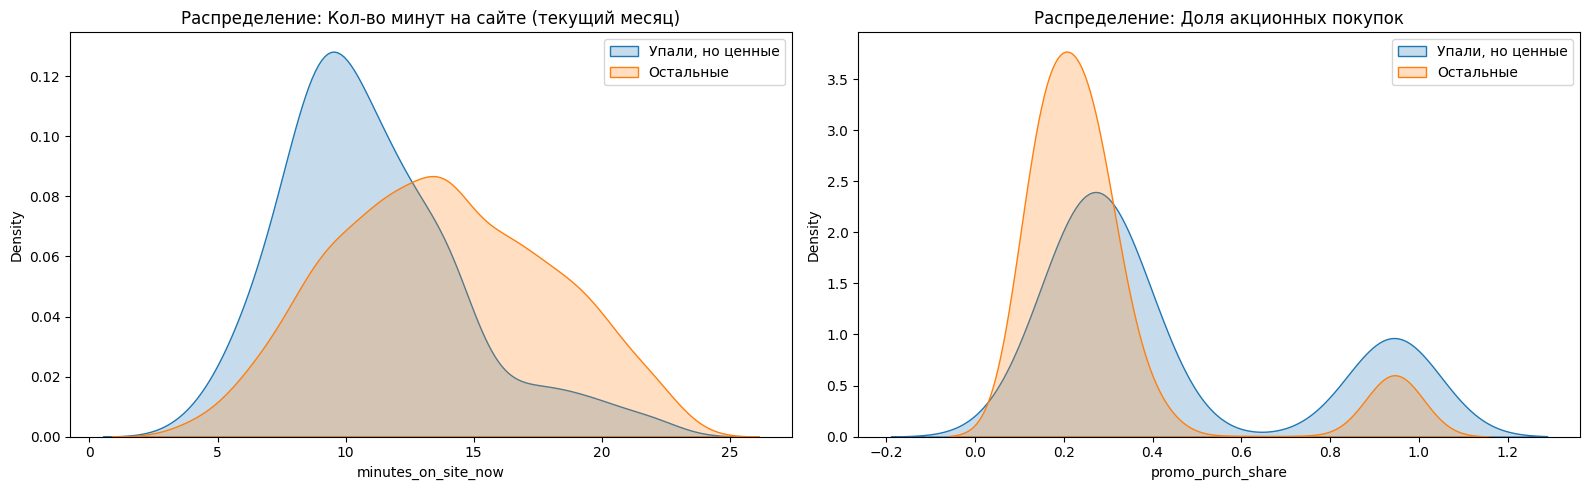

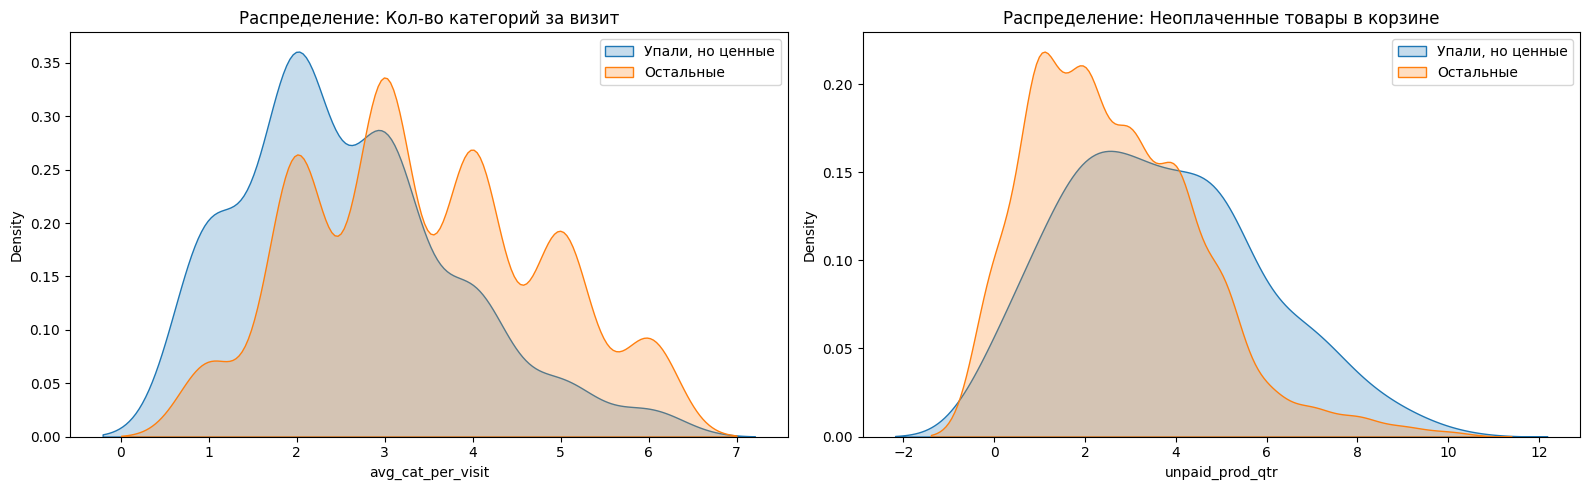

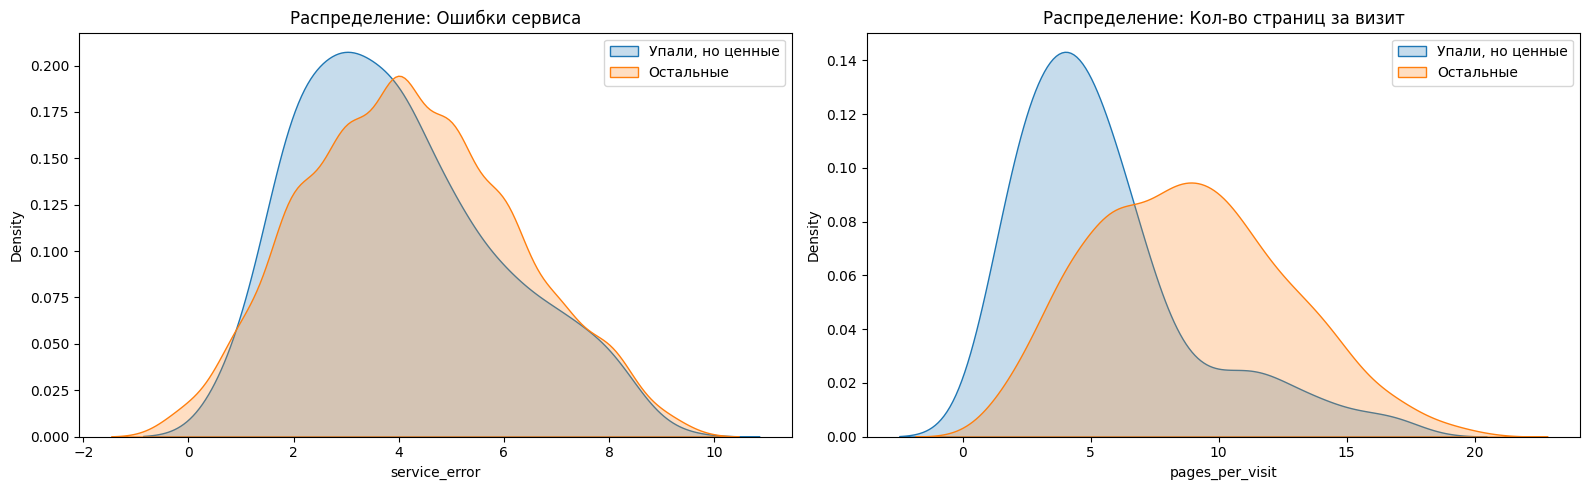

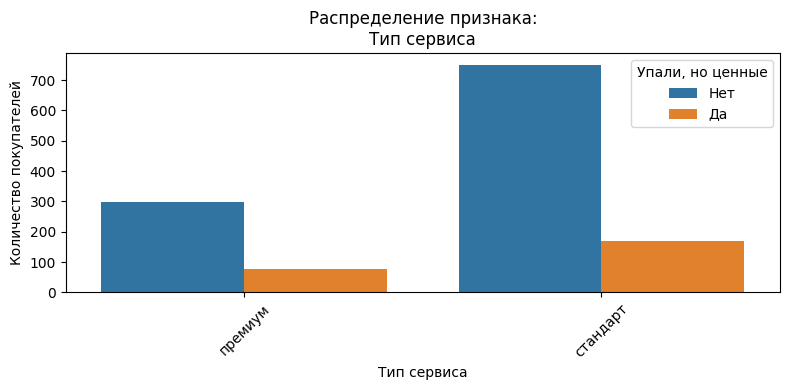

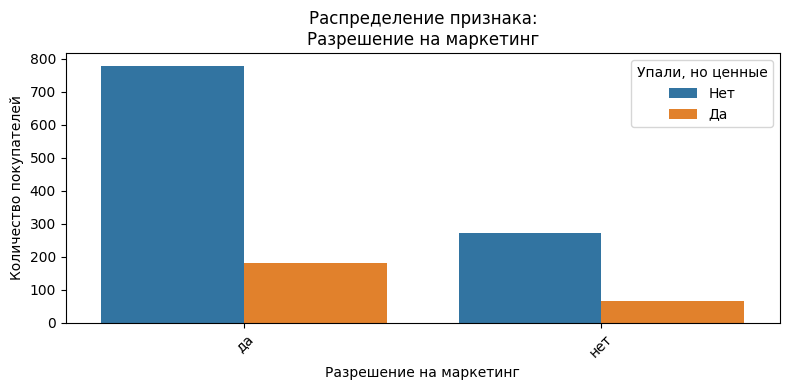

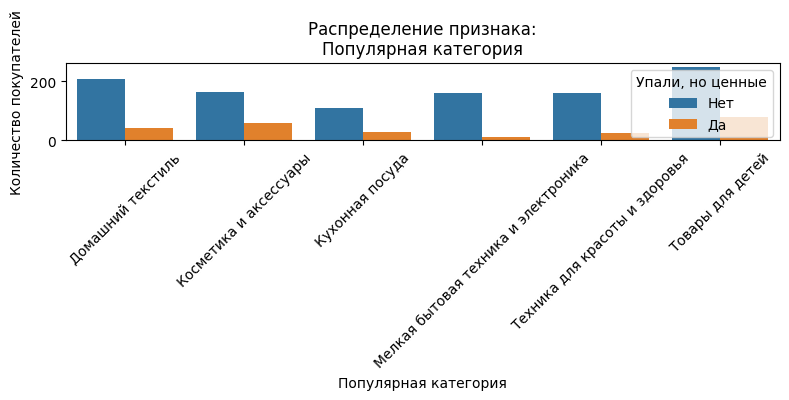

In [67]:
# Отбор сегмента "Упали, но ценные"
valuable_fallen = market_segmentation[market_segmentation['segment'] == 'Упали, но ценные']
non_segment = market_segmentation[market_segmentation['segment'] != 'Упали, но ценные']
market_segmentation['is_valuable_fallen'] = market_segmentation['segment'] == 'Упали, но ценные'

# Признаки для анализа
features = {
    'minutes_on_site_now': 'Кол-во минут на сайте (текущий месяц)',
    'promo_purch_share': 'Доля акционных покупок',
    'avg_cat_per_visit': 'Кол-во категорий за визит',
    'unpaid_prod_qtr': 'Неоплаченные товары в корзине',
    'service_error': 'Ошибки сервиса',
    'pages_per_visit': 'Кол-во страниц за визит'
}

# Сравнение распределений с остальными клиентами
for i in range(0, len(features), 2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    for j in range(2):
        if i + j < len(features):
            feat_key = list(features.keys())[i + j]
            feat_label = features[feat_key]
            sns.kdeplot(
                valuable_fallen[feat_key],
                label='Упали, но ценные',
                fill=True,
                ax=axes[j]
            )
            sns.kdeplot(
                non_segment[feat_key],
                label='Остальные',
                fill=True,
                ax=axes[j]
            )
            axes[j].set_title(f'Распределение: {feat_label}')
            axes[j].legend()

    plt.tight_layout()
    plt.show()


# Анализ категориальных переменных по сегменту
# Словарь читаемых названий для категориальных признаков
cat_feature_labels = {
    'service_type': 'Тип сервиса',
    'allow_msg': 'Разрешение на маркетинг',
    'popular_cat': 'Популярная категория'
}

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=market_segmentation, x=col, hue='is_valuable_fallen')
    
    readable_label = cat_feature_labels.get(col, col)
    plt.title(f'Распределение признака:\n{readable_label}')
    plt.xlabel(readable_label)
    plt.ylabel('Количество покупателей')
    
    plt.legend(title='Упали, но ценные', labels=['Нет', 'Да'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

1. Количество минут на сайте (текущий месяц)
Сегмент «Упали, но ценные» тратит меньше времени на сайте, чем остальные.
Это может указывать на снижение интереса или активности — повод вернуть внимание.


2. Доля акционных покупок
У ценных клиентов доля акционных покупок ниже, чем у остальных.
Возможно, эта группа ориентирована не на скидки, а на ценность — их может не привлекать «акционная коммуникация».


3. Количество категорий за визит
Ценные клиенты в среднем смотрят меньше категорий, чем остальные.
Это может говорить о более целенаправленном поведении — они приходят за конкретным, но теперь делают это реже.


4. Неоплаченные товары в корзине
В этом сегменте чуть выше доля неоплаченных товаров.
Возможная гипотеза: что-то мешает завершить покупку (технические барьеры, недостаток мотивации).


5. Ошибки сервиса
Распределение смещено в сторону большего числа ошибок у «упавших, но ценных».
Это может быть важным фактором ухода — стоит проверить UX / ошибки на пути к покупке.


6. Количество страниц за визит
Ценные клиенты смотрят меньше страниц за визит.
Это может говорить о поверхностном взаимодействии или быстром отказе от покупки.


7. Тип сервиса
В сегменте преобладает «стандарт», а не «премиум».
Возможно, текущий уровень обслуживания не соответствует ожиданиям этой аудитории.


8. Разрешение на маркетинг
Ушедшие ценные клиенты реже дают разрешение на маркетинг.
Мы теряем канал связи — стоит подумать о ненавязчивых способах повторного вовлечения.


9. Популярная категория
Сегмент чаще покупает домашний текстиль и кухонную посуду, реже — детские товары.
Значит, маркетинг должен быть сегментирован и сфокусирован именно на этих категориях.


Таким образом сегмент «Упали, но ценные» проявляет меньше активности по всем поведенческим метрикам, но сохраняет признаки высокой прибыльности.
Вероятно снижение вовлечённости, ошибки на сайте, отсутствие индивидуальных офферов.

Рекомендации:
- Упростить UX и устранить сервисные ошибки;
- Запустить офферы в их категориях интереса (не через агрессивные скидки);
- Настроить персональные сценарии возврата (например, напоминание о брошенной корзине без давления);
- А/B тестировать гипотезы на этой группе.

#### Общий вывод

Цель проекта — построить модель, которая предсказывает вероятность снижения покупательской активности клиентов интернет-магазина «В один клик». Задача направлена на удержание постоянных клиентов и повышение их вовлечённости через персонализированные предложения. Дополнительно была выполнена сегментация клиентов по прибыльности и активности, чтобы разработать индивидуальные стратегии взаимодействия.

Было выполнено:
- Использовались данные из нескольких таблиц
- Данные были объединены по id
- Удалены аномалии
- Закодированы категориальные признаки (OneHotEncoder и OrdinalEncoder);
- Применено масштабирование количественных признаков (MinMaxScaler, StandardScaler);
- Исключён признак id как нерелевантный.
- проведен поиск лучшей модели
- Были обучены и оценены 4 модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC.
- Использовался пайплайн с ColumnTransformer, разделяющий обработку категориальных и числовых признаков.
- Гиперпараметры подбирались с помощью GridSearchCV.
- Основная метрика — ROC-AUC, приоритет также отдавался Recall (важна минимизация пропуска ухода клиентов).

Лучшая модель
Наилучший результат показала модель DecisionTreeClassifier с подобранными параметрами (max_depth=5, max_features=8, class_weight=balanced).

ROC-AUC на тестовой выборке: ~0.88
Recall: ~0.73
F1-score: ~0.76

С помощью метода SHAP проанализирована важность признаков:
- Наибольшее влияние оказали: pages_per_visit, promo_purch_share, minutes_on_site_now, service_error, avg_cat_per_visit.
- Признаки, слабо влияющие на модель: service_type, popular_cat.

Сегментация клиентов выполнена по двум признакам: прибыли и активности. Выделены группы:

- 💎 Лояльные и выгодные
- 🤝 Лояльные, но дешёвые
- ⚠️ Упали, но ценные
- ❌ Ушли и невыгодные

Для анализа выбрана группа "Упали, но ценные" — это клиенты с высокой прибылью, но сниженной активностью.

Предложения для этого сегмента:
- Персонализированные промоакции для возвращения интереса (чувствительность к скидкам подтверждена);
- Упростить UX и устранить сервисные ошибки (часто фиксировались service_error);
- Повышение вовлечённости через упрощение пути к покупке и напоминания о товарах в корзине.
- Запустить офферы в их категориях интереса (не через агрессивные скидки);
- А/B тестировать гипотезы на этой группе.